In [ ]:
!pip install pillow Augmentor requests
!pip install pillow Augmentor
!pip install Pillow
!pip install tensorflow
!pip install Augmentor
!pip install shutil

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [ ]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
import pandas as pd
from PIL import Image
import random
import requests
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import preprocess_input
import Augmentor
from io import BytesIO
import os
from IPython.display import Image as IPImage, display
import urllib.request
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import shutil
import cv2



In [ ]:
# Assuming the CSV file is named "skin_tone_dataset.csv", adjust the filename as per your dataset.
csv_file = "/content/drive/MyDrive/fitzpatrick17k.csv"

# Load the CSV data into a pandas DataFrame
data = pd.read_csv(csv_file)

# Display the first few rows of the dataset to get an overview of the data
print(data.head())

                            md5hash  fitzpatrick_scale  fitzpatrick_centaur  \
0  5e82a45bc5d78bd24ae9202d194423f8                  3                    3   
1  fa2911a9b13b6f8af79cb700937cc14f                  1                    1   
2  d2bac3c9e4499032ca8e9b07c7d3bc40                  2                    3   
3  0a94359e7eaacd7178e06b2823777789                  1                    1   
4  a39ec3b1f22c08a421fa20535e037bba                  1                    1   

                             label nine_partition_label three_partition_label  \
0  drug induced pigmentary changes         inflammatory        non-neoplastic   
1                  photodermatoses         inflammatory        non-neoplastic   
2                   dermatofibroma        benign dermal                benign   
3                        psoriasis         inflammatory        non-neoplastic   
4                        psoriasis         inflammatory        non-neoplastic   

    qc                                

In [ ]:
# Define the unique Fitzpatrick scale values in the dataset
fitzpatrick_values = [1, 2, 3, 4, 5, 6]

# Create a dictionary to hold data for each client node
client_data_dict = {value: None for value in fitzpatrick_values}

# Split the data and assign to each client based on Fitzpatrick scale values
for value in fitzpatrick_values:
    client_data_dict[value] = data[data['fitzpatrick_scale'] == value]

# Display the size of each client's data
for value, client_data in client_data_dict.items():
    print(f"Client {value} data size: {len(client_data)}")

# If needed, you can save the data for each client into separate CSV files
for value, client_data in client_data_dict.items():
    client_data.to_csv(f"client_{value}_data.csv", index=False)

NameError: ignored

In [ ]:
##This code for download images from csv files url
import os
import pandas as pd
import requests

# Define the function to download an image
def download_image(url, filename):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Image downloaded from {url} to {filename}")
    else:
        print(f"Error downloading image from {url}. HTTP {response.status_code}")

# Load the CSV data into a pandas DataFrame
csv_file = "/content/drive/MyDrive/client_2_data.csv"
client_data = pd.read_csv(csv_file)

# Folder to save the downloaded images
output_base_folder = "/content/drive/MyDrive/Client2_Images"
if not os.path.exists(output_base_folder):
    os.makedirs(output_base_folder)

# Iterate through the DataFrame and download images category-wise
for index, row in client_data.iterrows():
    url = row['url']
    category = row['three_partition_label']  # Assuming 'three_partition_label' is the category column name

    # Skip if URL is empty
    if pd.isna(url) or not url.strip():
        print(f"Skipping row {index} due to empty URL.")
        continue

    # Skip if category is empty or not one of the expected categories
    if pd.isna(category) or category not in ["non-neoplastic", "malignant", "benign"]:
        print(f"Skipping row {index} due to invalid category: {category}")
        continue

    category_folder = os.path.join(output_base_folder, category)
    if not os.path.exists(category_folder):
        os.makedirs(category_folder)

    filename = os.path.join(category_folder, f"image_{index}.jpg")

    # Validate the URL format
    if not url.startswith(("http://", "https://")):
        print(f"Invalid URL format for index {index}: {url}")
        continue  # Skip this iteration

    # Attempt to download the image
    try:
        download_image(url, filename)
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/d/dermatofibroma/dermatofibroma71.jpg to /content/drive/MyDrive/Client2_Images/benign/image_0.jpg
Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/s/sweet-syndrome/sweet-syndrome98.jpg to /content/drive/MyDrive/Client2_Images/non-neoplastic/image_1.jpg
Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/g/granuloma_annulare/granuloma_annulare41.jpg to /content/drive/MyDrive/Client2_Images/non-neoplastic/image_2.jpg
Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/L/lmm/lmm6.jpg to /content/drive/MyDrive/Client2_Images/malignant/image_3.jpg
Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/s/sarcoidosis-of-the-skin-plaque-form/sarcoidosis-of-the-skin-plaque-form15.jpg to /content/drive/MyDrive/Client2_Images/non-neoplastic/image_4.jpg
Image downloaded from https://www.dermaamin.com/site/images/clinical-pic/d/dermatofibroma/d

In [ ]:
import os

# Define the path to the Round 1 folder
client_Images = "/content/drive/MyDrive/Client2_Images"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Create a dictionary to store the image counts for each category in Round 1
image_counts = {}

# Iterate through each category and count the images in Round 1
for category in categories:
    category_folder = os.path.join(client_Images, category)
    image_count = len(os.listdir(category_folder))
    image_counts[category] = image_count

# Print the image counts for Round 1
for category, count in image_counts.items():
    print(f"Category: {category}, Image Count: {count}")

Category: non-neoplastic, Image Count: 3383
Category: malignant, Image Count: 742
Category: benign, Image Count: 671


In [ ]:
##This code for 50 resize image and splitting for training, validation and testing
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

# Define the base directory where your category-wise images are stored
base_dir = "/content/drive/MyDrive/Client2_Images"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define the path to the output folders
output_folder = "/content/drive/MyDrive/Client2_SplitData"

# Define the target size for resizing
target_size = (256, 256)

# Create the output folders if they don't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through the categories and split the data
for category in categories:
    # Create subfolders for each category
    category_train_folder = os.path.join(output_folder, "train", category)
    category_validation_folder = os.path.join(output_folder, "validation", category)
    category_test_folder = os.path.join(output_folder, "test", category)

    os.makedirs(category_train_folder, exist_ok=True)
    os.makedirs(category_validation_folder, exist_ok=True)
    os.makedirs(category_test_folder, exist_ok=True)

    category_folder = os.path.join(base_dir, category)
    image_file_names = os.listdir(category_folder)

    # Split the data into train, validation, and test sets
    train_files, test_files = train_test_split(image_file_names, test_size=0.2, random_state=42)
    train_files, validation_files = train_test_split(train_files, test_size=0.25, random_state=42)

    # Resize and move files to respective folders
    for filename in train_files:
        src_path = os.path.join(category_folder, filename)
        dst_path = os.path.join(category_train_folder, filename)

        # Open and resize the image
        img = Image.open(src_path)
        img = img.resize(target_size)
        img.save(dst_path)

    for filename in validation_files:
        src_path = os.path.join(category_folder, filename)
        dst_path = os.path.join(category_validation_folder, filename)

        # Open and resize the image
        img = Image.open(src_path)
        img = img.resize(target_size)
        img.save(dst_path)

    for filename in test_files:
        src_path = os.path.join(category_folder, filename)
        dst_path = os.path.join(category_test_folder, filename)

        # Open and resize the image
        img = Image.open(src_path)
        img = img.resize(target_size)
        img.save(dst_path)

print("Image resizing and splitting complete.")


Image resizing and splitting complete.


In [ ]:
import os

# Define the base directory where your data is stored
base_dir = "/content/drive/MyDrive/Client6_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Create dictionaries to store counts for each category and dataset
category_counts = {category: {} for category in categories}

# Iterate through the categories and datasets
for category in categories:
    for dataset in ["train", "validation", "test"]:
        category_folder = os.path.join(base_dir, dataset, category)
        num_images = len(os.listdir(category_folder))
        category_counts[category][dataset] = num_images

# Print the counts
for category, counts in category_counts.items():
    print(f"Category: {category}")
    for dataset, num_images in counts.items():
        print(f"  {dataset}: {num_images} images")

# Create a dictionary to store total images for each category
category_total_counts = {category: sum(counts.values()) for category, counts in category_counts.items()}

# Calculate the overall total across all categories
overall_total = sum(category_total_counts.values())

# Print the total images for each category
for category, total_count in category_total_counts.items():
    print(f"Total images in '{category}' category: {total_count}")

# Print the overall total across all categories
print(f"Overall total number of images: {overall_total}")



Category: non-neoplastic
  train: 314 images
  validation: 105 images
  test: 105 images
Category: malignant
  train: 36 images
  validation: 12 images
  test: 12 images
Category: benign
  train: 26 images
  validation: 9 images
  test: 9 images
Total images in 'non-neoplastic' category: 524
Total images in 'malignant' category: 60
Total images in 'benign' category: 44
Overall total number of images: 628


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
##DenseNet201 Apply
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client1_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, "validation"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# # Print additional information about the generators
# print(f"Found {train_generator.samples} train images belonging to {len(categories)} classes.")
# print(f"Found {validation_generator.samples} validation images belonging to {len(categories)} classes.")
# print(f"Found {test_generator.samples} test images belonging to {len(categories)} classes.")


# Define the DenseNet201 model with transfer learning
base_model = DenseNet201(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 60

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy}")

# Save the model
model.save("/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5")


Found 1762 images belonging to 3 classes.
Found 589 images belonging to 3 classes.
Found 590 images belonging to 3 classes.
Epoch 1/60
55/55 [==============================] - 871s 15s/step - loss: 0.7870 - accuracy: 0.6994 - val_loss: 1.1002 - val_accuracy: 0.6962
Epoch 2/60
55/55 [==============================] - 800s 15s/step - loss: 0.6110 - accuracy: 0.7705 - val_loss: 0.8075 - val_accuracy: 0.7188
Epoch 3/60
55/55 [==============================] - 793s 14s/step - loss: 0.5292 - accuracy: 0.8017 - val_loss: 0.6922 - val_accuracy: 0.7500
Epoch 4/60
55/55 [==============================] - 798s 15s/step - loss: 0.4347 - accuracy: 0.8410 - val_loss: 0.7897 - val_accuracy: 0.7292
Epoch 5/60
55/55 [==============================] - 759s 14s/step - loss: 0.3698 - accuracy: 0.8532 - val_loss: 0.7712 - val_accuracy: 0.7535
Epoch 6/60
55/55 [==============================] - 787s 14s/step - loss: 0.2808 - accuracy: 0.8948 - val_loss: 0.8882 - val_accuracy: 0.7448
Epoch 7/60
55/55 [======

In [ ]:
#apply resnet50
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client1_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (224, 224)  # ResNet50's default input size is 224x224

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, "validation"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Define the ResNet50 model with transfer learning
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 60

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy}")

# Save the model
model.save("/content/drive/MyDrive/Final_Client1_ResNet50_60epoch_Model.h5")


4/4 [==============================] - 15s 2s/step
Confusion Matrix:
[[ 0  0  9]
 [ 1  0 11]
 [ 6  4 95]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.00      0.00      0.00         9
     malignant       0.00      0.00      0.00        12
non-neoplastic       0.83      0.90      0.86       105

      accuracy                           0.75       126
     macro avg       0.28      0.30      0.29       126
  weighted avg       0.69      0.75      0.72       126



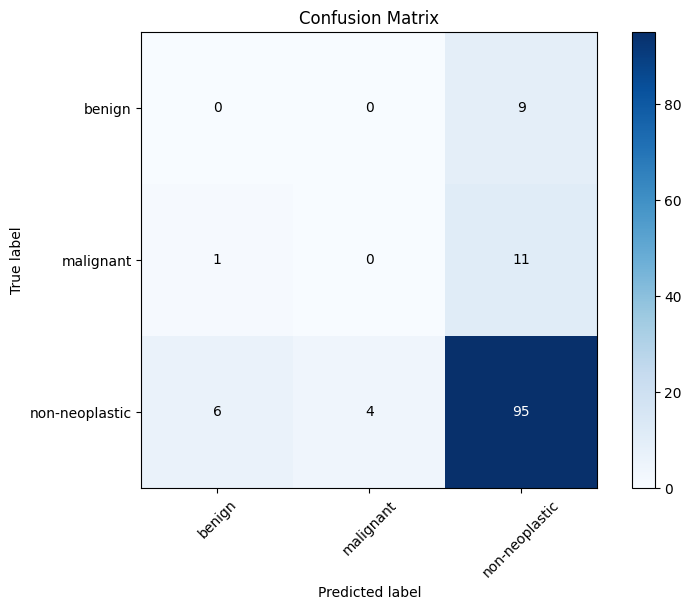

In [ ]:
##Client 6 Confusion Matrix densenet
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Reload the saved model
saved_model_path = "/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



In [ ]:
import tensorflow as tf

# Load the saved model
saved_model_path = "/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5"
loaded_model = tf.keras.models.load_model(saved_model_path)

# Access the last layer's weights
last_layer_weights = loaded_model.layers[-1].get_weights()

# Print the last layer weights
print(last_layer_weights)

[array([[-0.03874128,  0.03880387,  0.00201457],
       [ 0.05690316,  0.0215448 ,  0.00739675],
       [ 0.05390005,  0.06620044, -0.03885923],
       ...,
       [-0.03474297, -0.06504186,  0.06775018],
       [ 0.02170339, -0.07403765,  0.03133194],
       [-0.03985413, -0.02790423,  0.03928527]], dtype=float32), array([-0.00250085, -0.00270628,  0.00383199], dtype=float32)]


In [ ]:
import tensorflow as tf
import numpy as np

# List of paths to the saved models from clients
client_model_paths = [
    "/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5",
    "/content/drive/MyDrive/Final_Client2_DenseNet201_60epoch_Model.h5",
    "/content/drive/MyDrive/Final_Client3_DenseNet201_60epoch_Model.h5",
    "/content/drive/MyDrive/Final_Client4_DenseNet201_60epoch_Model.h5",
    "/content/drive/MyDrive/Final_Client5_DenseNet201_60epoch_Model.h5",
    "/content/drive/MyDrive/Final_Client6_DenseNet201_60epoch_Model.h5"
]

# Load only the last layer of each client's model
client_last_layer_weights = []

for model_path in client_model_paths:
    model = tf.keras.models.load_model(model_path)
    last_layer_weights = model.layers[-1].get_weights()
    client_last_layer_weights.append(last_layer_weights)

# Calculate the average of last layer weights
average_last_layer_weights = np.mean(client_last_layer_weights, axis=0)

# Create a new model with the same architecture as the client models
average_model = tf.keras.models.clone_model(tf.keras.models.load_model(client_model_paths[0]))

# Set the weights of the last layer of the average model to the calculated average
average_model.layers[-1].set_weights(average_last_layer_weights)

# Save the average model
average_model.save("/content/drive/MyDrive/Avg_Weights_Clients_DenseNet201_Model.h5")

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os

file_path = "/content/drive/MyDrive/Avg_Weights_Clients_DenseNet201_Model.h5"
from keras.models import load_model

loaded_model = load_model(file_path)

# Print model summary
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']      

In [ ]:
# Get the last layer
last_layer = loaded_model.layers[-1]

# Get the weights of the last layer
last_layer_weights = last_layer.get_weights()

# Print the weights
print("Last Layer Weights:")
print(last_layer_weights)

Last Layer Weights:
[array([[ 0.00126039, -0.0075828 ,  0.00643343],
       [ 0.01107302, -0.00022077, -0.01222635],
       [-0.00211392,  0.01448261,  0.02637383],
       ...,
       [-0.01427713, -0.0165184 ,  0.01534038],
       [-0.00316196,  0.00293763,  0.01036174],
       [-0.01743606, -0.00734676,  0.01577678]], dtype=float32), array([-0.00115032, -0.00148429,  0.00192918], dtype=float32)]


Found 590 images belonging to 3 classes.


19/19 [==============================] - 68s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[  0   0  89]
 [  0   0  91]
 [  0   0 410]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.00      0.00      0.00        89
     malignant       0.00      0.00      0.00        91
non-neoplastic       0.69      1.00      0.82       410

      accuracy                           0.69       590
     macro avg       0.23      0.33      0.27       590
  weighted avg       0.48      0.69      0.57       590



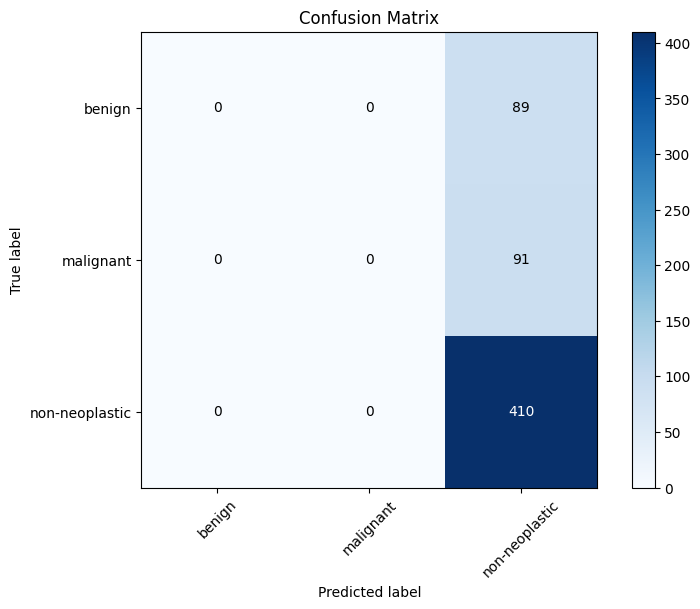

In [ ]:
##Client 1 avg weight
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client1_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Avg_Weights_Clients_DenseNet201_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Paths to the saved models
model_paths = [
    '/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5',
    '/content/drive/MyDrive/Final_Client2_DenseNet201_60epoch_Model.h5',
    '/content/drive/MyDrive/Final_Client3_DenseNet201_60epoch_Model.h5',
    '/content/drive/MyDrive/Final_Client4_DenseNet201_60epoch_Model.h5',
    '/content/drive/MyDrive/Final_Client5_DenseNet201_60epoch_Model.h5',
    '/content/drive/MyDrive/Final_Client6_DenseNet201_60epoch_Model.h5'
]

# Load models
client_models = [load_model(path) for path in model_paths]

# Get the last layer weights from each model
last_layer_weights = [model.layers[-1].get_weights() for model in client_models]

# Separate weight matrix and bias vector
average_weights_matrix = tf.reduce_mean([weights[0] for weights in last_layer_weights], axis=0)
average_bias_vector = tf.reduce_mean([weights[1] for weights in last_layer_weights], axis=0)

# Create a new model with the same architecture as one of the clients
reference_model = load_model(model_paths[0])

# Set the weights of the last layer to the average weights
reference_model.layers[-1].set_weights([average_weights_matrix, average_bias_vector])

# Save the model with average weights
reference_model.save('/content/drive/MyDrive/Average_Weights_Model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 590 images belonging to 3 classes.
19/19 [==============================] - 57s 3s/step
Confusion Matrix:
[[ 13  15  61]
 [ 13  12  66]
 [ 65  53 292]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.14      0.15      0.14        89
     malignant       0.15      0.13      0.14        91
non-neoplastic       0.70      0.71      0.70       410

      accuracy                           0.54       590
     macro avg       0.33      0.33      0.33       590
  weighted avg       0.53      0.54      0.53       590



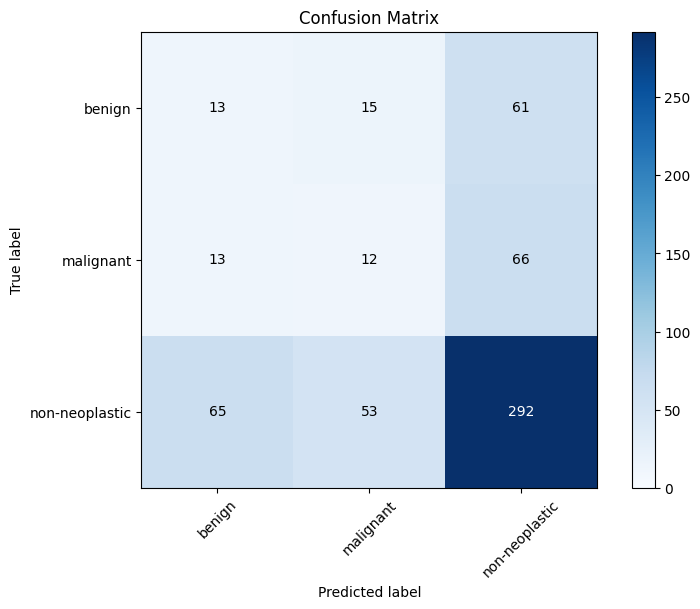

In [ ]:
##Client 1
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client1_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client1_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 590 images belonging to 3 classes.
19/19 [==============================] - 53s 3s/step
Confusion Matrix:
[[  6  13  70]
 [  6   9  76]
 [ 35  46 329]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.13      0.07      0.09        89
     malignant       0.13      0.10      0.11        91
non-neoplastic       0.69      0.80      0.74       410

      accuracy                           0.58       590
     macro avg       0.32      0.32      0.31       590
  weighted avg       0.52      0.58      0.55       590



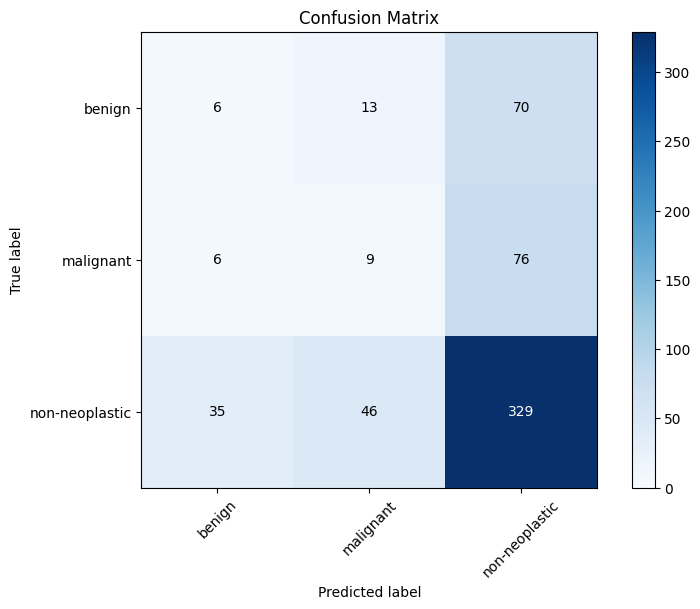

In [ ]:
##Client 1 avg weight
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client1_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 202 images belonging to 3 classes.
7/7 [==============================] - 24s 3s/step
Confusion Matrix:
[[ 2  4 20]
 [ 3  4 37]
 [16 25 91]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.10      0.08      0.09        26
     malignant       0.12      0.09      0.10        44
non-neoplastic       0.61      0.69      0.65       132

      accuracy                           0.48       202
     macro avg       0.28      0.29      0.28       202
  weighted avg       0.44      0.48      0.46       202



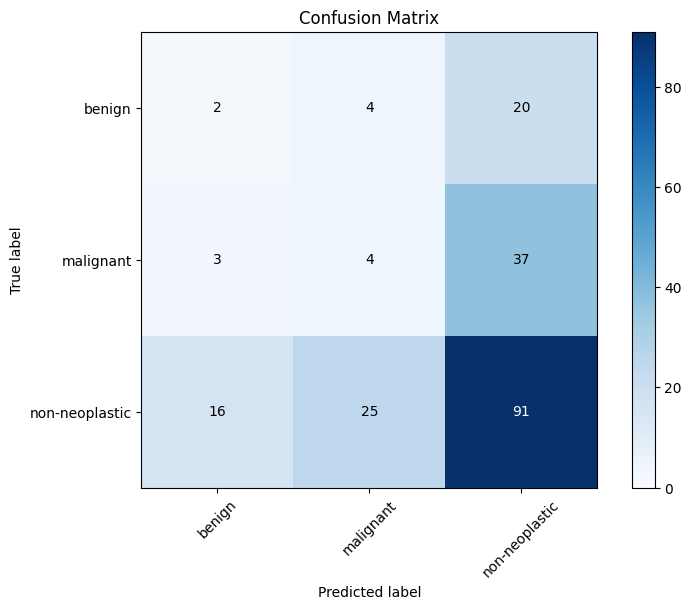

In [ ]:
##Client 2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client2_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client2_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 202 images belonging to 3 classes.
7/7 [==============================] - 19s 2s/step
Confusion Matrix:
[[ 5  7 14]
 [ 4 12 28]
 [11 28 93]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.25      0.19      0.22        26
     malignant       0.26      0.27      0.26        44
non-neoplastic       0.69      0.70      0.70       132

      accuracy                           0.54       202
     macro avg       0.40      0.39      0.39       202
  weighted avg       0.54      0.54      0.54       202



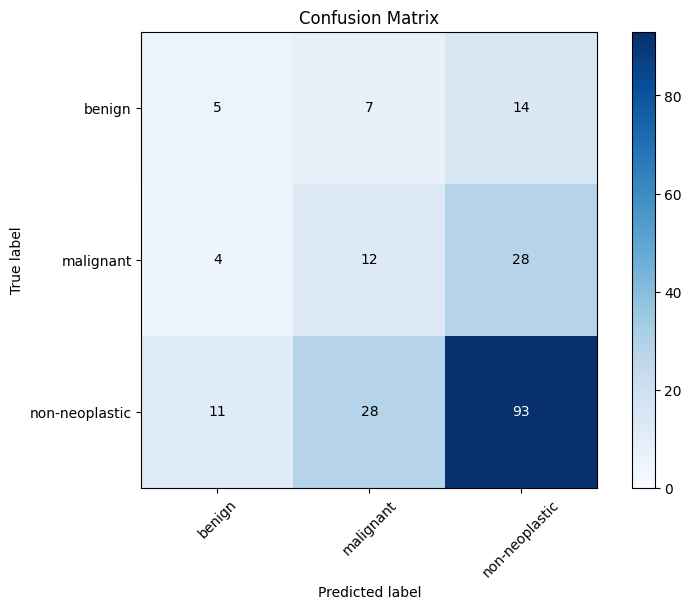

In [ ]:
##Client 2 avg
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client2_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 661 images belonging to 3 classes.
21/21 [==============================] - 55s 2s/step
Confusion Matrix:
[[  7  10  78]
 [  8   9  75]
 [ 53  41 380]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.10      0.07      0.09        95
     malignant       0.15      0.10      0.12        92
non-neoplastic       0.71      0.80      0.75       474

      accuracy                           0.60       661
     macro avg       0.32      0.32      0.32       661
  weighted avg       0.55      0.60      0.57       661



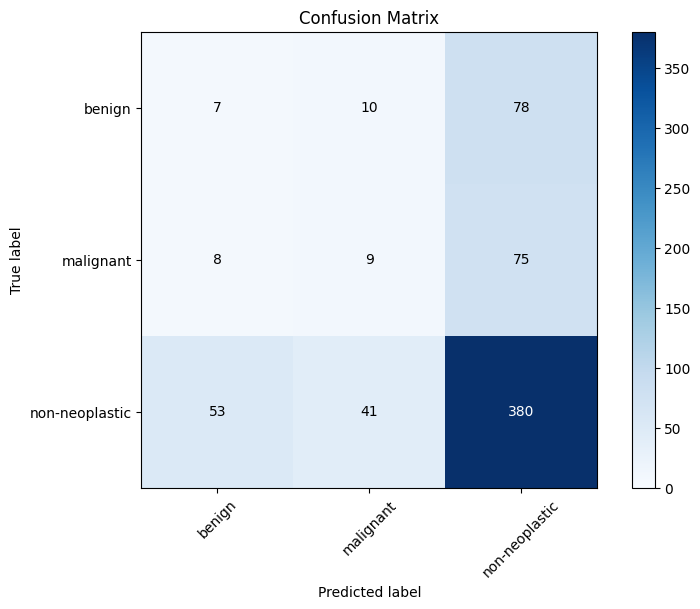

In [ ]:
##Client 3
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client3_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client3_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 661 images belonging to 3 classes.
21/21 [==============================] - 51s 2s/step
Confusion Matrix:
[[ 11  10  74]
 [  6   7  79]
 [ 27  55 392]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.25      0.12      0.16        95
     malignant       0.10      0.08      0.09        92
non-neoplastic       0.72      0.83      0.77       474

      accuracy                           0.62       661
     macro avg       0.36      0.34      0.34       661
  weighted avg       0.57      0.62      0.59       661



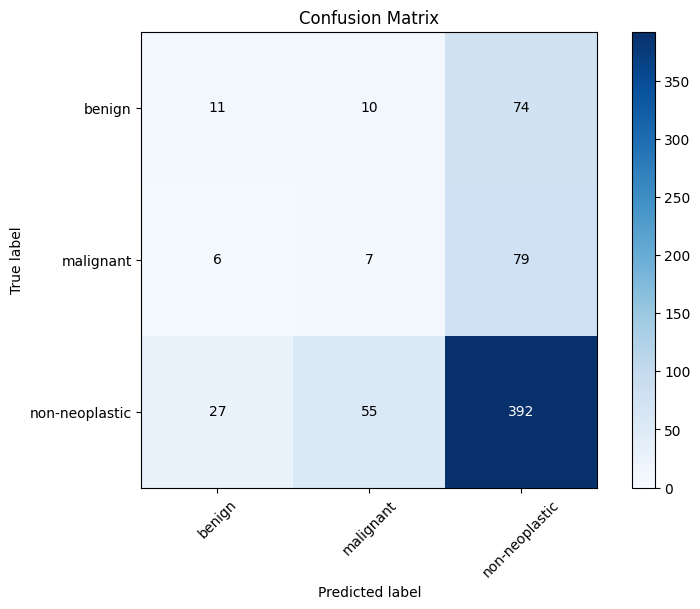

In [ ]:
##Client 3 avg
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client3_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 557 images belonging to 3 classes.
18/18 [==============================] - 45s 2s/step
Confusion Matrix:
[[  9   6  59]
 [  8   2  51]
 [ 58  14 350]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.12      0.12      0.12        74
     malignant       0.09      0.03      0.05        61
non-neoplastic       0.76      0.83      0.79       422

      accuracy                           0.65       557
     macro avg       0.32      0.33      0.32       557
  weighted avg       0.60      0.65      0.62       557



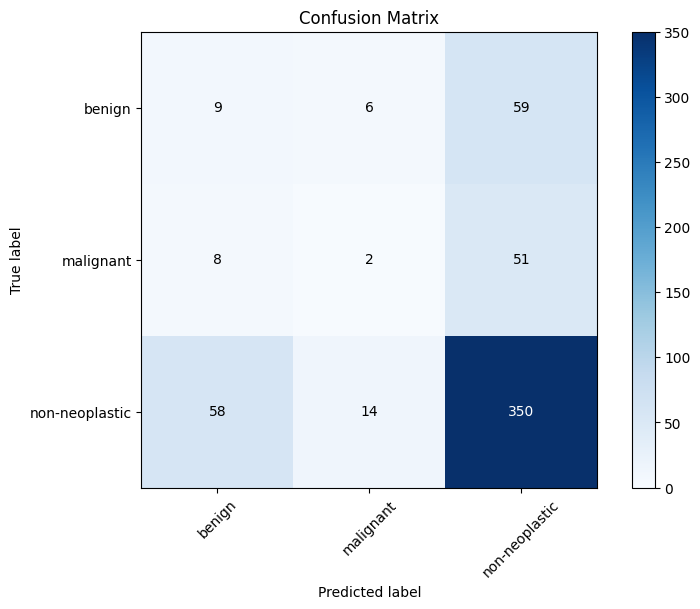

In [ ]:
##Client 4
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client4_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client4_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 557 images belonging to 3 classes.
18/18 [==============================] - 44s 2s/step
Confusion Matrix:
[[  2   9  63]
 [  5   6  50]
 [ 31  33 358]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.05      0.03      0.04        74
     malignant       0.12      0.10      0.11        61
non-neoplastic       0.76      0.85      0.80       422

      accuracy                           0.66       557
     macro avg       0.31      0.32      0.32       557
  weighted avg       0.60      0.66      0.62       557



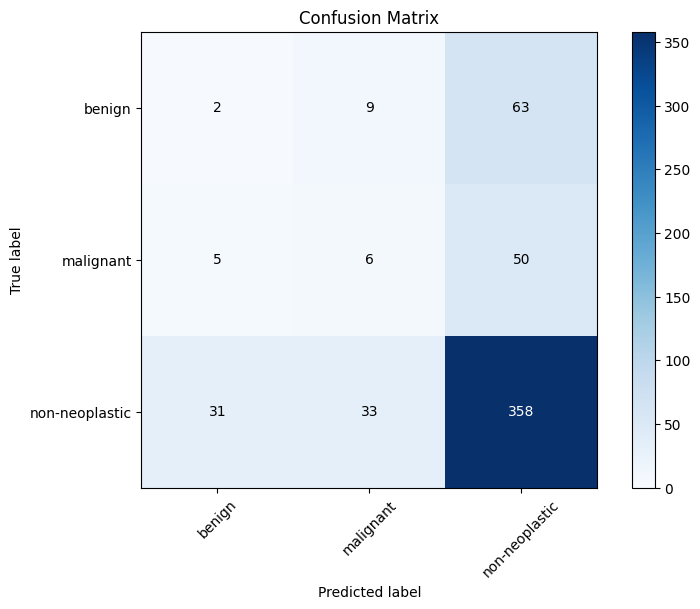

In [ ]:
##Client 4 avg
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client4_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 307 images belonging to 3 classes.
10/10 [==============================] - 48s 5s/step
Confusion Matrix:
[[  3   1  28]
 [  1   2  27]
 [  6  11 228]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.30      0.09      0.14        32
     malignant       0.14      0.07      0.09        30
non-neoplastic       0.81      0.93      0.86       245

      accuracy                           0.76       307
     macro avg       0.42      0.36      0.37       307
  weighted avg       0.69      0.76      0.71       307



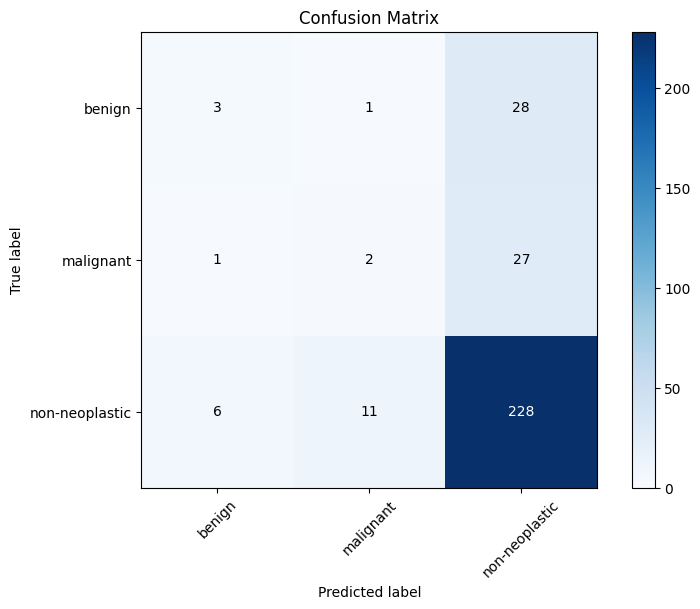

In [ ]:
##Client 5
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client5_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client5_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 307 images belonging to 3 classes.
10/10 [==============================] - 28s 2s/step
Confusion Matrix:
[[  2   3  27]
 [  2   4  24]
 [ 22  22 201]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.08      0.06      0.07        32
     malignant       0.14      0.13      0.14        30
non-neoplastic       0.80      0.82      0.81       245

      accuracy                           0.67       307
     macro avg       0.34      0.34      0.34       307
  weighted avg       0.66      0.67      0.67       307



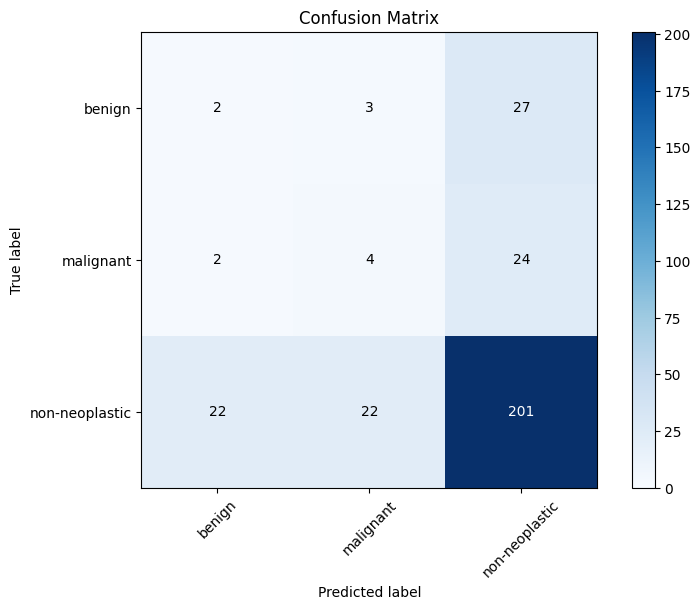

In [ ]:
##Client 5 avg
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client5_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 126 images belonging to 3 classes.
4/4 [==============================] - 17s 2s/step
Confusion Matrix:
[[ 1  0  8]
 [ 0  0 12]
 [ 6  1 98]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.14      0.11      0.12         9
     malignant       0.00      0.00      0.00        12
non-neoplastic       0.83      0.93      0.88       105

      accuracy                           0.79       126
     macro avg       0.32      0.35      0.33       126
  weighted avg       0.70      0.79      0.74       126



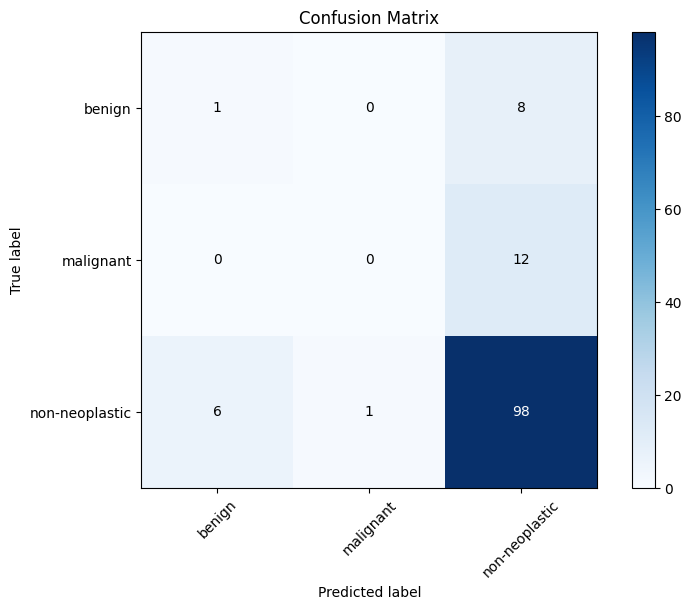

In [ ]:
##Client 6
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client6_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Final_Client6_DenseNet201_60epoch_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



Found 126 images belonging to 3 classes.
4/4 [==============================] - 13s 2s/step
Confusion Matrix:
[[ 1  1  7]
 [ 0  2 10]
 [ 5  8 92]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.17      0.11      0.13         9
     malignant       0.18      0.17      0.17        12
non-neoplastic       0.84      0.88      0.86       105

      accuracy                           0.75       126
     macro avg       0.40      0.38      0.39       126
  weighted avg       0.73      0.75      0.74       126



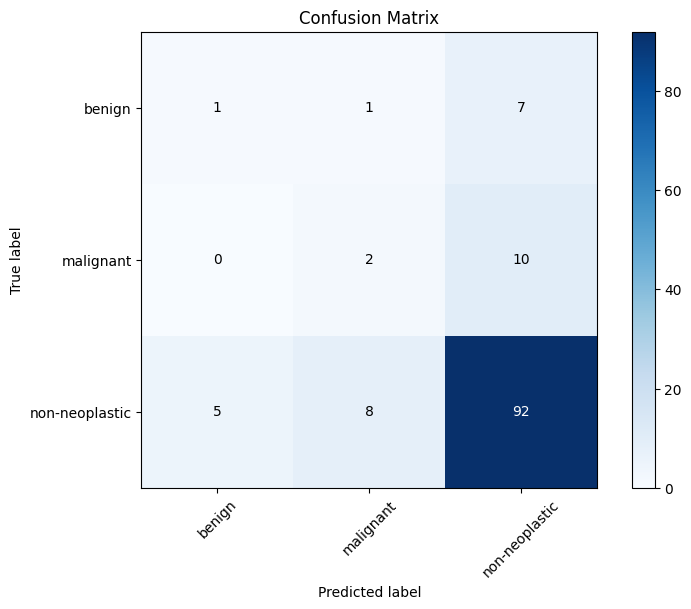

In [ ]:
##Client 6 avg
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client6_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Average_Weights_Model.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



In [ ]:
##This code for 20 Round Folder Creation
import os
import shutil
import random
from PIL import Image

# Define the base directory where your downloaded images are stored
base_dir = "/content/drive/MyDrive/Client2_Images"

# Define the number of rounds
num_rounds = 20

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Create the Client1_Folder
client_folder = "/content/drive/MyDrive/Client2_Folder"
os.makedirs(client_folder, exist_ok=True)

# Define the target size for resizing
target_size = (128, 128)

# Iterate through each round
for round_num in range(1, num_rounds + 1):
    round_folder = os.path.join(client_folder, f"Round_{round_num}")
    os.makedirs(round_folder, exist_ok=True)

    # Create a list to track images already added to this round
    added_images = []

    # Iterate through each category
    for category in categories:
        category_folder = os.path.join(base_dir, category)
        round_category_folder = os.path.join(round_folder, category)
        os.makedirs(round_category_folder, exist_ok=True)

        # List all images in the category folder
        category_images = os.listdir(category_folder)

        # Calculate how many images to add to this round (total / num_rounds)
        num_images_to_add = len(category_images) // num_rounds

        # Shuffle the images to ensure randomness
        random.shuffle(category_images)

        # Add unique images to this round
        added_count = 0
        for image in category_images:
            if image not in added_images:
                src_path = os.path.join(category_folder, image)
                dst_path = os.path.join(round_category_folder, image)

                # Open and resize the image
                img = Image.open(src_path)
                img = img.resize(target_size)
                img.save(dst_path)

                # Mark the image as added
                added_images.append(image)
                added_count += 1

            # Check if we've added enough images for this round
            if added_count >= num_images_to_add:
                break

print("Round creation and image resizing complete.")


Round creation and image resizing complete.


In [ ]:
import os

# Define the path to the Round 1 folder
round_1_folder = "/content/drive/MyDrive/Client6_Folder/Round_1"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Create a dictionary to store the image counts for each category in Round 1
image_counts = {}

# Iterate through each category and count the images in Round 1
for category in categories:
    category_folder = os.path.join(round_1_folder, category)
    image_count = len(os.listdir(category_folder))
    image_counts[category] = image_count

# Print the image counts for Round 1
for category, count in image_counts.items():
    print(f"Category: {category}, Image Count: {count}")

Category: non-neoplastic, Image Count: 26
Category: malignant, Image Count: 3
Category: benign, Image Count: 2


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

# Set the base directory where client folders are stored
base_clients_dir = "C:\\Users\\Heraa\\Desktop\\fitzlearning"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define the number of rounds
num_rounds = 20

# Define the target size for resizing
target_size = (128, 128)

# Iterate through each round
for round_num in range(1, num_rounds + 1):
    # Initialize a list to store the last layer weights of each client's model for the current round
    last_layer_weights_list = []

    # Iterate through each client folder for the current round
    for client_num in range(1, 7):
        client_folder = os.path.join(base_clients_dir, f"Client{client_num}_Folder")
        current_round_folder = os.path.join(client_folder, f"Round_{round_num}")

        # Build the model for the current round
        base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(len(categories), activation='softmax')  # Assuming 'categories' is defined
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Define the data directory for training
        train_data_dir = current_round_folder

        # Parameters for training
        batch_size = 32
        epochs = 10

        # Create data generators for training
        train_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Train the model for the current round
        model.fit(train_generator, epochs=epochs)

        # Save the trained model
        model_save_path = os.path.join(client_folder, f"Client{client_num}_Round{round_num}_DenseNet201.h5")
        model.save(model_save_path)
        print(f"Model for Client{client_num} Round_{round_num} trained and saved at: {model_save_path}")

        # Load the saved model weights for the current round
        model.load_weights(model_save_path)

        # Extract and store the last layer weights for computing the average later
        last_layer_weights_list.append(model.layers[-1].get_weights())

    # Compute the average weights of the last layer for the current round across all clients
    average_last_layer_weights = np.mean(last_layer_weights_list, axis=0)

    # Iterate through each client folder for the next round (Round_{round_num+1})
    for client_num in range(1, 7):
        client_folder = os.path.join(base_clients_dir, f"Client{client_num}_Folder")
        next_round_folder = os.path.join(client_folder, f"Round_{round_num+1}")

        # Build the model for the next round and set the average last layer weights as initial weights
        base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(len(categories), activation='softmax')  # Assuming 'categories' is defined
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Set the average last layer weights as initial weights
        model.layers[-1].set_weights(average_last_layer_weights)

        # Train the model for the next round
        batch_size = 32
        epochs = 10  # You can adjust the number of epochs as needed
        train_data_dir = next_round_folder
        train_datagen = ImageDataGenerator(rescale=1./255)
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical'
        )
        model.fit(train_generator, epochs=epochs)

        # Save the trained model for the next round
        model_save_path = os.path.join(client_folder, f"Client{client_num}_Round{round_num+1}_DenseNet201.h5")
        model.save(model_save_path)
        print(f"Model for Client{client_num} Round_{round_num+1} trained and saved at: {model_save_path}")


Found 557 images belonging to 3 classes.
18/18 [==============================] - 43s 2s/step
Confusion Matrix:
[[  3   2  69]
 [  1   3  57]
 [  9  14 399]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.23      0.04      0.07        74
     malignant       0.16      0.05      0.07        61
non-neoplastic       0.76      0.95      0.84       422

      accuracy                           0.73       557
     macro avg       0.38      0.35      0.33       557
  weighted avg       0.62      0.73      0.66       557



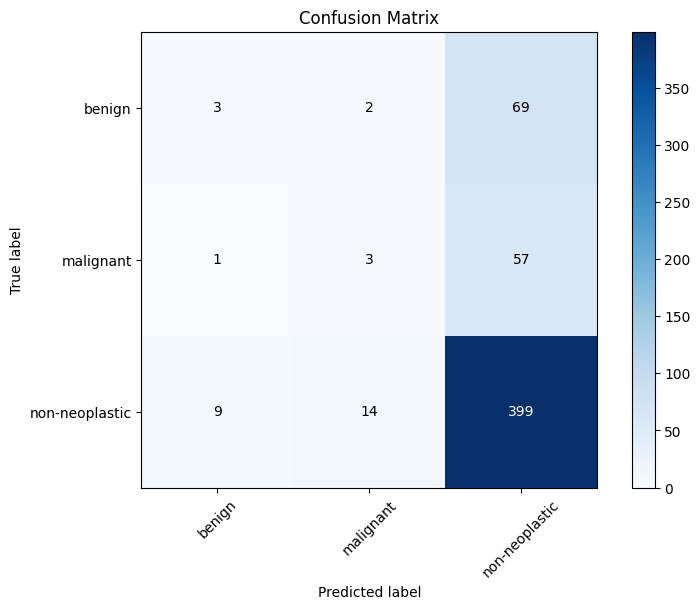

In [ ]:
##Client 6
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client4_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Client4_Round20_DenseNet201.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Show the plots
plt.show()



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight


# Set the base directory where client folders are stored
base_clients_dir = "/content/drive/MyDrive"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define the number of rounds
num_rounds = 20

# Define the target size for resizing
target_size = (128, 128)

# Function to compute class weights
def compute_weights(train_generator):
    class_labels = []
    for _, labels in train_generator:
        class_labels.extend(np.argmax(labels, axis=1))
        if len(class_labels) >= len(train_generator.classes):
            break

    unique_classes = np.unique(class_labels)
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)
    class_weight_dict = {class_idx: weight for class_idx, weight in zip(unique_classes, class_weights)}

    return class_weight_dict

# Iterate through each round
for round_num in range(1, num_rounds + 1):
    # Initialize a list to store the last layer weights of each client's model for the current round
    last_layer_weights_list = []

    # Iterate through each client folder for the current round
    for client_num in range(1, 7):
        client_folder = os.path.join(base_clients_dir, f"Client{client_num}_Folder")
        current_round_folder = os.path.join(client_folder, f"Round_{round_num}")

        # Build the model for the current round
        base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(len(categories), activation='softmax')  # Assuming 'categories' is defined
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Define the data directory for training
        train_data_dir = current_round_folder

        # Parameters for training
        batch_size = 32
        epochs = 1

        # Create data generators for training with data augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Compute class weights
        class_weights = compute_weights(train_generator)

        # Train the model for the current round with class weights
        model.fit(train_generator, epochs=epochs, class_weight=class_weights)

        # Save the trained model
        model_save_path = os.path.join(client_folder, f"Client{client_num}_Round{round_num}_DenseNet201.h5")
        model.save(model_save_path)
        print(f"Model for Client{client_num} Round_{round_num} trained and saved at: {model_save_path}")

        # Load the saved model weights for the current round
        model.load_weights(model_save_path)

        # Extract and store the last layer weights for computing the average later
        last_layer_weights_list.append(model.layers[-1].get_weights())

    # Compute the average weights of the last layer for the current round across all clients
    average_last_layer_weights = []
    # Iterate over each element in the last_layer_weights_list
    for weights in zip(*last_layer_weights_list):
        # Compute the mean of the weights for each element across all clients
        average_weights = np.mean(weights, axis=0)
        average_last_layer_weights.append(average_weights)

    # Convert the list of average weights to a numpy array
    average_last_layer_weights = np.array(average_last_layer_weights)

    # Iterate through each client folder for the next round (Round_{round_num+1})
    for client_num in range(1, 7):
        client_folder = os.path.join(base_clients_dir, f"Client{client_num}_Folder")
        next_round_folder = os.path.join(client_folder, f"Round_{round_num+1}")

        # Build the model for the next round and set the average last layer weights as initial weights
        base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(len(categories), activation='softmax')  # Assuming 'categories' is defined
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Set the average last layer weights as initial weights
        model.layers[-1].set_weights(average_last_layer_weights)

        # Train the model for the next round with class weights
        train_data_dir = next_round_folder
        train_datagen = ImageDataGenerator(rescale=1./255)
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical'
        )
        model.fit(train_generator, epochs=epochs, class_weight=class_weights)

        # Save the trained model for the next round
        model_save_path = os.path.join(client_folder, f"Client{client_num}_Round{round_num+1}_DenseNet201.h5")
        model.save(model_save_path)
        print(f"Model for Client{client_num} Round_{round_num+1} trained and saved at: {model_save_path}")


Found 146 images belonging to 3 classes.
5/5 [==============================] - 26s 2s/step - loss: 1.2079 - accuracy: 0.3151


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client1 Round_1 trained and saved at: /content/drive/MyDrive/Client1_Folder/Client1_Round1_DenseNet201.h5
Found 239 images belonging to 3 classes.
8/8 [==============================] - 33s 2s/step - loss: 1.5108 - accuracy: 0.2552


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client2 Round_1 trained and saved at: /content/drive/MyDrive/Client2_Folder/Client2_Round1_DenseNet201.h5
Found 163 images belonging to 3 classes.
6/6 [==============================] - 26s 2s/step - loss: 1.3771 - accuracy: 0.2577


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client3 Round_1 trained and saved at: /content/drive/MyDrive/Client3_Folder/Client3_Round1_DenseNet201.h5
Found 138 images belonging to 3 classes.
5/5 [==============================] - 26s 2s/step - loss: 1.4523 - accuracy: 0.3406


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client4 Round_1 trained and saved at: /content/drive/MyDrive/Client4_Folder/Client4_Round1_DenseNet201.h5
Found 75 images belonging to 3 classes.
3/3 [==============================] - 18s 1s/step - loss: 1.8267 - accuracy: 0.5733


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client5 Round_1 trained and saved at: /content/drive/MyDrive/Client5_Folder/Client5_Round1_DenseNet201.h5
Found 31 images belonging to 3 classes.
1/1 [==============================] - 16s 16s/step - loss: 1.5759 - accuracy: 0.4839


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for Client6 Round_1 trained and saved at: /content/drive/MyDrive/Client6_Folder/Client6_Round1_DenseNet201.h5


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Found 961 images belonging to 3 classes.
31/31 [==============================] - 73s 2s/step
Confusion Matrix:
[[  6  18 111]
 [ 14  15 120]
 [ 41  50 586]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.10      0.04      0.06       135
     malignant       0.18      0.10      0.13       149
non-neoplastic       0.72      0.87      0.78       677

      accuracy                           0.63       961
     macro avg       0.33      0.34      0.33       961
  weighted avg       0.55      0.63      0.58       961



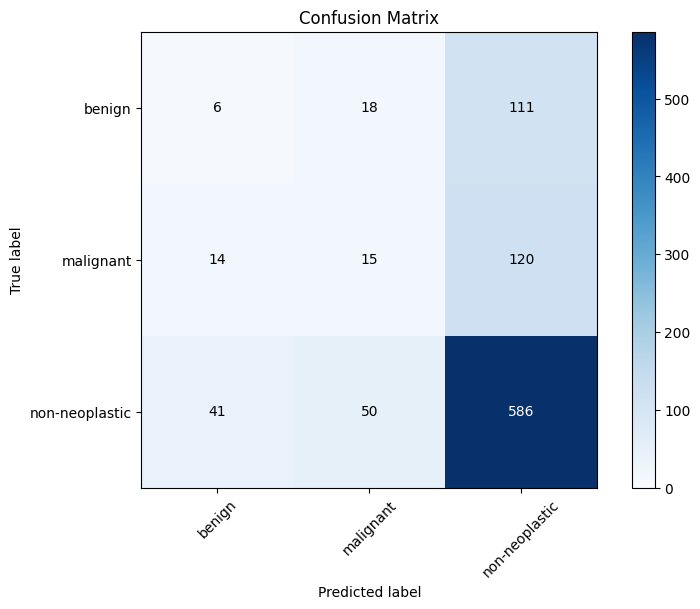

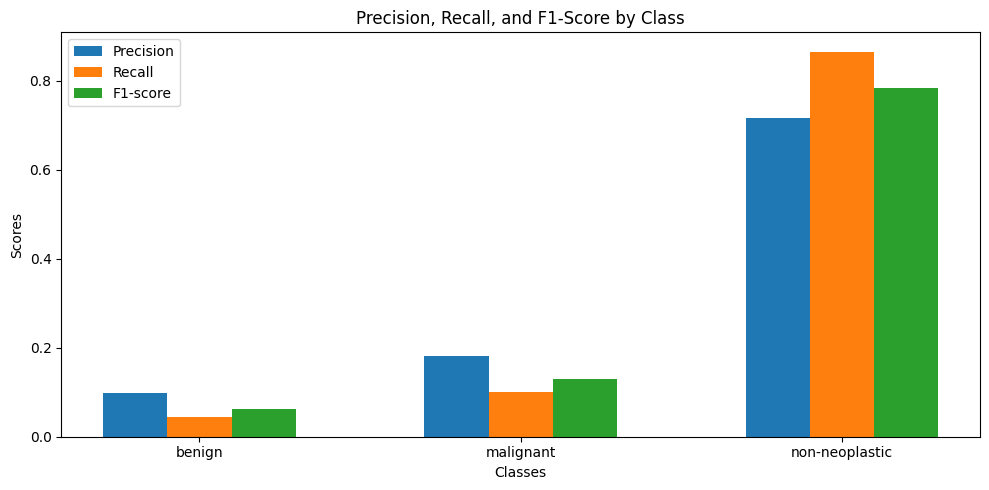

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Reload the saved model
# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client2_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Client2_Round20_DenseNet201.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Parse the classification report to get precision, recall, and f1-score
report_dict = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_labels]
recall = [report_dict[label]['recall'] for label in class_labels]
f1_score = [report_dict[label]['f1-score'] for label in class_labels]

# Plot precision, recall, and f1-score
plt.figure(figsize=(10, 5))
x = np.arange(len(class_labels))
bar_width = 0.2
plt.bar(x, precision, bar_width, label='Precision')
plt.bar(x + bar_width, recall, bar_width, label='Recall')
plt.bar(x + 2 * bar_width, f1_score, bar_width, label='F1-score')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score by Class')
plt.xticks(x + bar_width, class_labels)
plt.legend()
plt.tight_layout()
plt.show()


Found 307 images belonging to 3 classes.
10/10 [==============================] - 26s 2s/step
Confusion Matrix:
[[  0   0  32]
 [  0   0  30]
 [  2   4 239]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.00      0.00      0.00        32
     malignant       0.00      0.00      0.00        30
non-neoplastic       0.79      0.98      0.88       245

      accuracy                           0.78       307
     macro avg       0.26      0.33      0.29       307
  weighted avg       0.63      0.78      0.70       307



<ipython-input-16-c8ff5c8afa58>:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-16-c8ff5c8afa58>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-16-c8ff5c8afa58>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


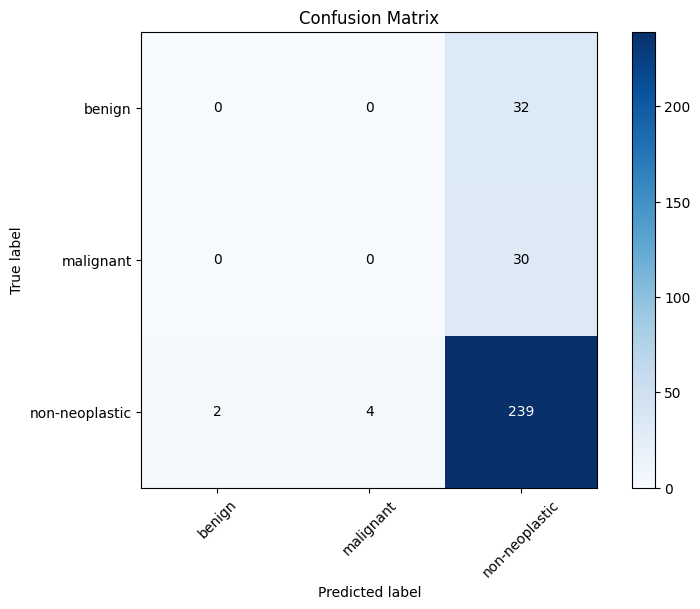

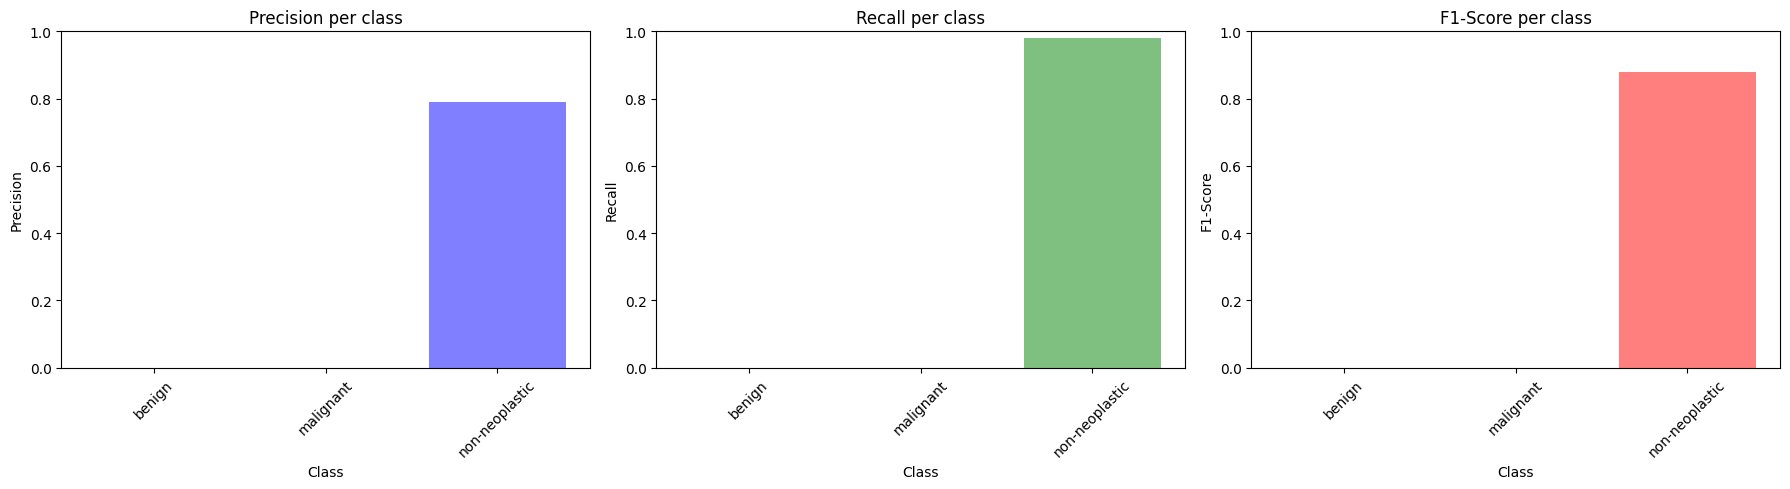

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/Client5_SplitData"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for training, validation, and test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

saved_model_path = "/content/drive/MyDrive/Client5_Round20_DenseNet201.h5"
model = load_model(saved_model_path)

# Use the test generator to make predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get class labels for the confusion matrix
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy, precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print accuracy, precision, recall, and F1-score
print("\nClassification Report:")
print(report)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(cm))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values inside the boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_labels)

# Plot precision, recall, and F1-score per class
def plot_metrics_per_class(classification_report):
    metrics_per_class = classification_report.split('\n')[2:-5]
    classes = [m.split()[0] for m in metrics_per_class]
    precision = [float(m.split()[1]) for m in metrics_per_class]
    recall = [float(m.split()[2]) for m in metrics_per_class]
    f1_score = [float(m.split()[3]) for m in metrics_per_class]

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].bar(classes, precision, color='b', alpha=0.5)
    ax[0].set_title('Precision per class')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlabel('Class')
    ax[0].set_xticklabels(classes, rotation=45)
    ax[0].set_ylim([0, 1])

    ax[1].bar(classes, recall, color='g', alpha=0.5)
    ax[1].set_title('Recall per class')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Class')
    ax[1].set_xticklabels(classes, rotation=45)
    ax[1].set_ylim([0, 1])

    ax[2].bar(classes, f1_score, color='r', alpha=0.5)
    ax[2].set_title('F1-Score per class')
    ax[2].set_ylabel('F1-Score')
    ax[2].set_xlabel('Class')
    ax[2].set_xticklabels(classes, rotation=45)
    ax[2].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

# Plot precision, recall, and F1-score per class
plot_metrics_per_class(report)


Evaluation for: /content/drive/MyDrive/Client1_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 46s 2s/step
Confusion Matrix:
[[  4   4  81]
 [  7   9  75]
 [ 26  37 347]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.11      0.04      0.06        89
     malignant       0.18      0.10      0.13        91
non-neoplastic       0.69      0.85      0.76       410

      accuracy                           0.61       590
     macro avg       0.33      0.33      0.32       590
  weighted avg       0.52      0.61      0.56       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


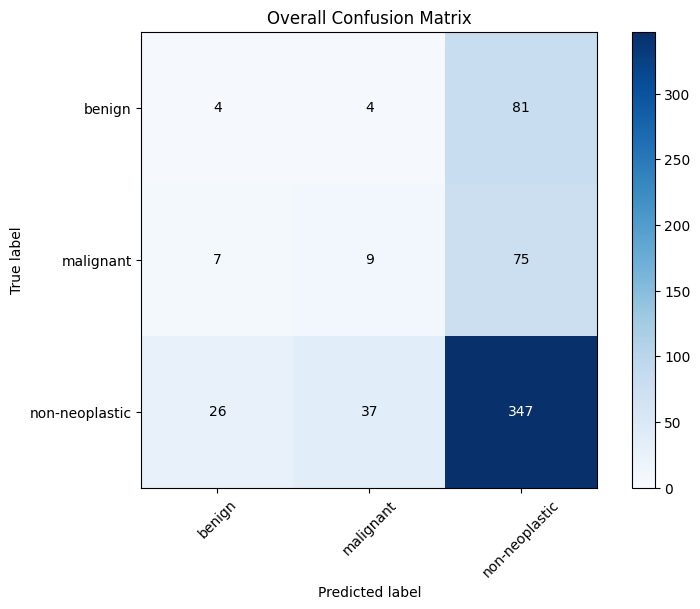

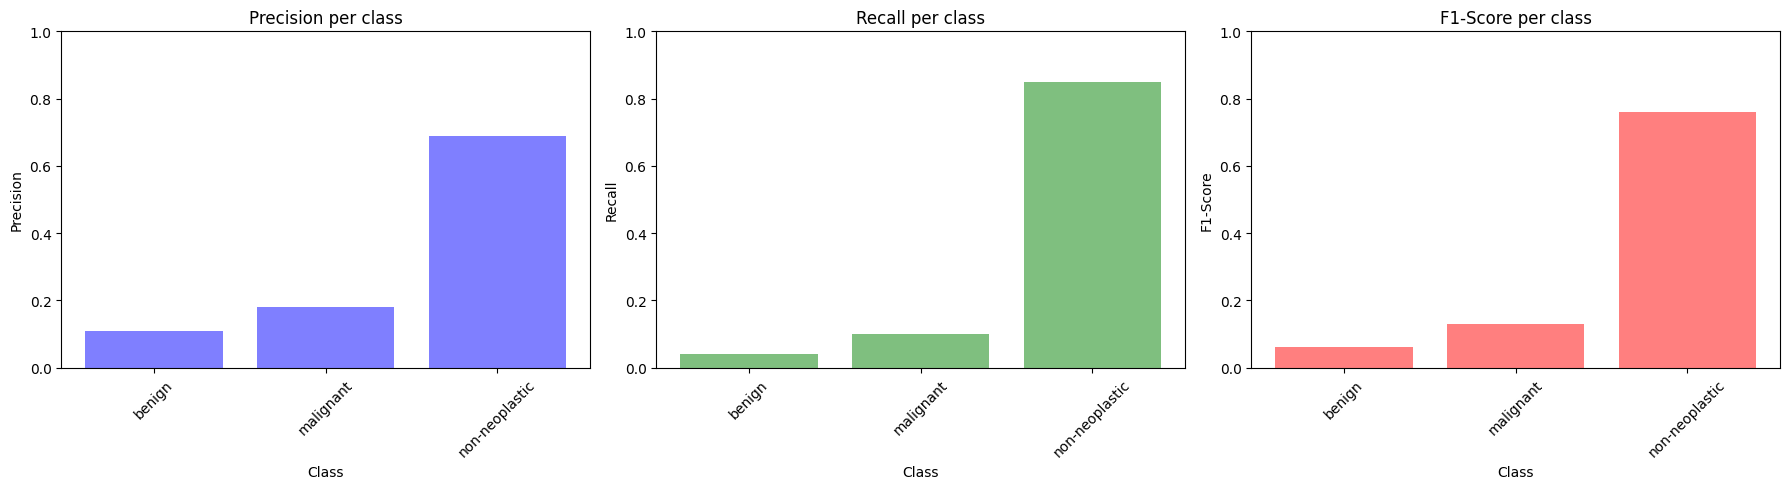

Evaluation for: /content/drive/MyDrive/Client2_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 45s 2s/step
Confusion Matrix:
[[  6   8  75]
 [  6   6  79]
 [ 38  36 336]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.12      0.07      0.09        89
     malignant       0.12      0.07      0.09        91
non-neoplastic       0.69      0.82      0.75       410

      accuracy                           0.59       590
     macro avg       0.31      0.32      0.31       590
  weighted avg       0.51      0.59      0.55       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


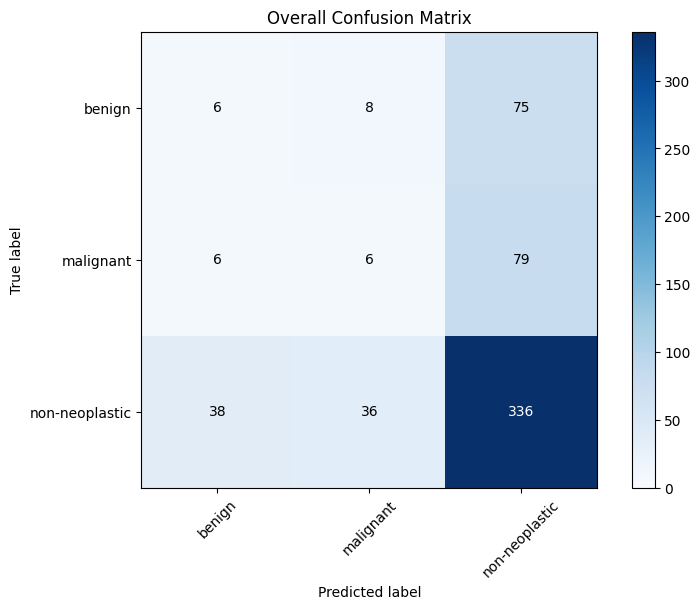

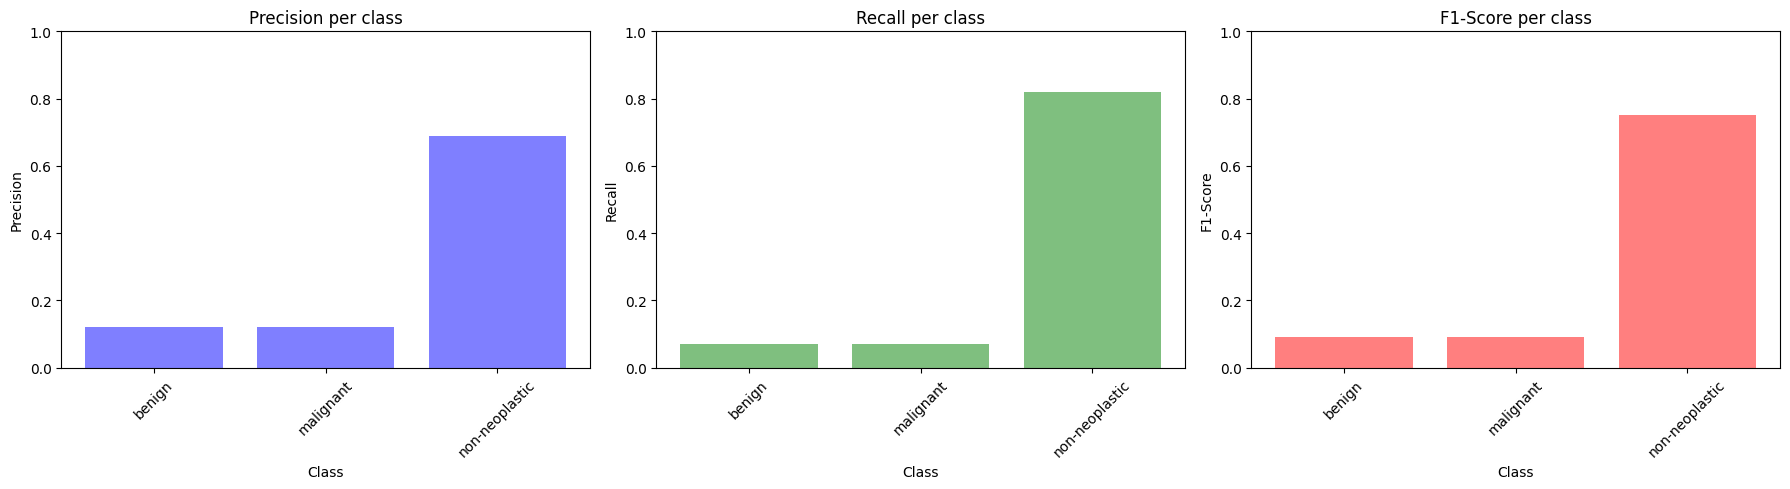

Evaluation for: /content/drive/MyDrive/Client3_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 45s 2s/step
Confusion Matrix:
[[  8   4  77]
 [  3   4  84]
 [ 23  15 372]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.24      0.09      0.13        89
     malignant       0.17      0.04      0.07        91
non-neoplastic       0.70      0.91      0.79       410

      accuracy                           0.65       590
     macro avg       0.37      0.35      0.33       590
  weighted avg       0.55      0.65      0.58       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


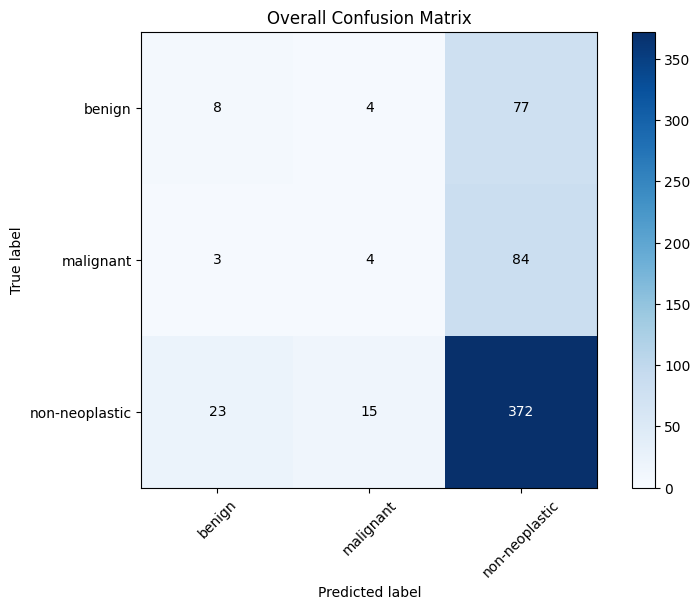

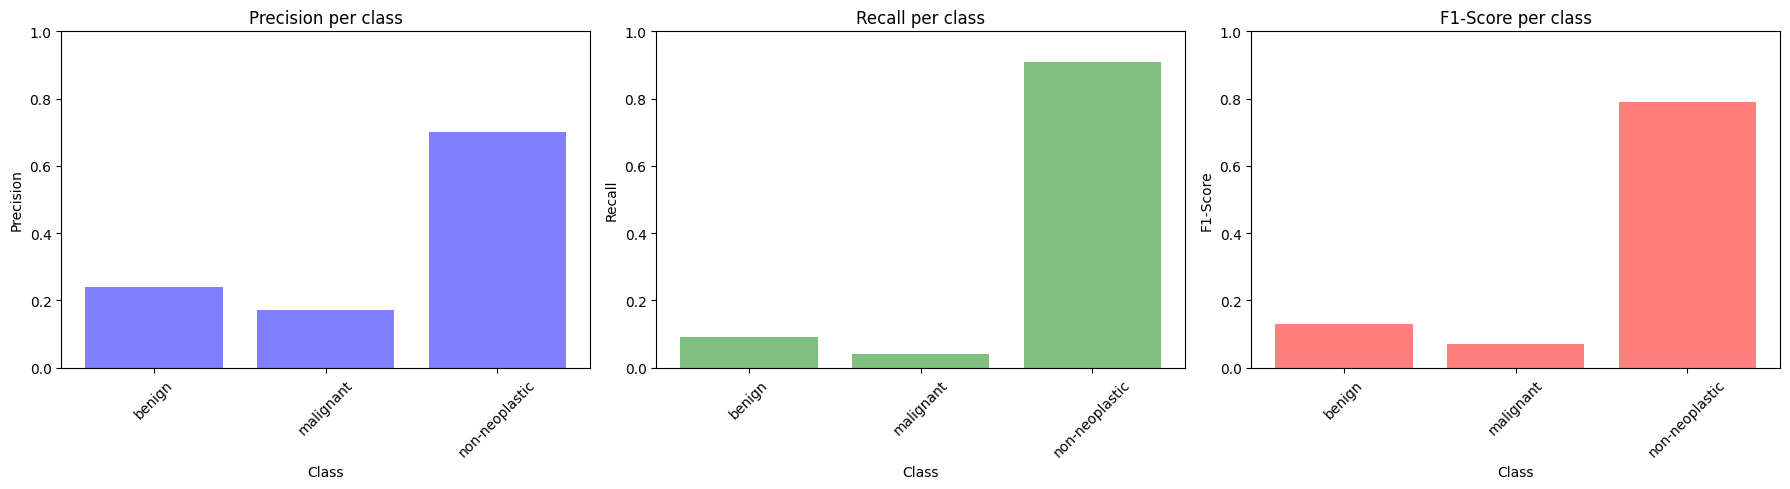

Evaluation for: /content/drive/MyDrive/Client4_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 47s 2s/step
Confusion Matrix:
[[  1   0  88]
 [  1   0  90]
 [ 20  13 377]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.05      0.01      0.02        89
     malignant       0.00      0.00      0.00        91
non-neoplastic       0.68      0.92      0.78       410

      accuracy                           0.64       590
     macro avg       0.24      0.31      0.27       590
  weighted avg       0.48      0.64      0.55       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


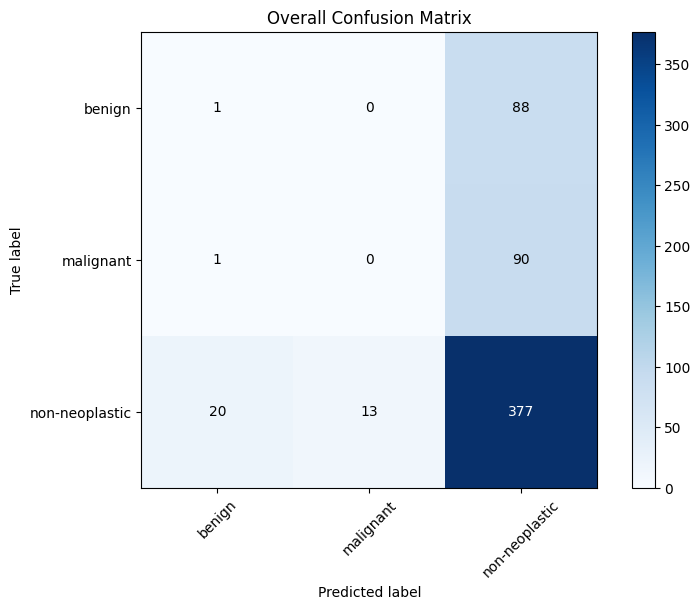

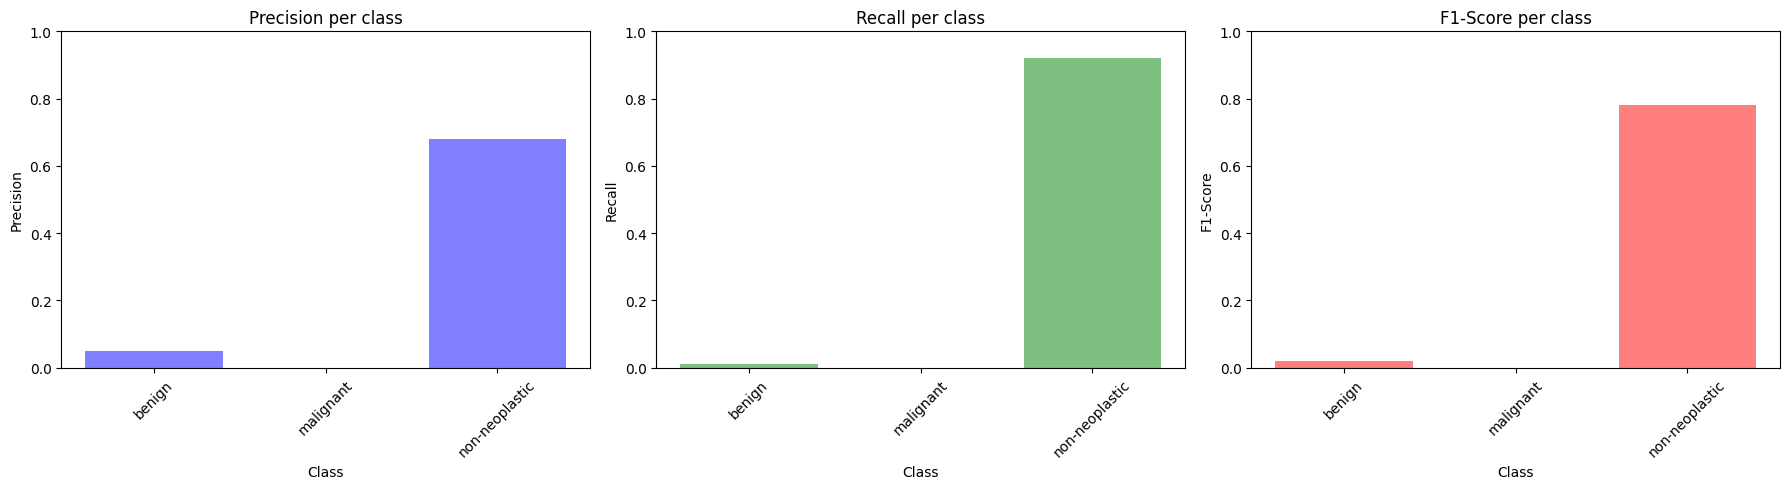

Evaluation for: /content/drive/MyDrive/Client5_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 45s 2s/step
Confusion Matrix:
[[  1   0  88]
 [  0   1  90]
 [  3   2 405]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.25      0.01      0.02        89
     malignant       0.33      0.01      0.02        91
non-neoplastic       0.69      0.99      0.82       410

      accuracy                           0.69       590
     macro avg       0.43      0.34      0.29       590
  weighted avg       0.57      0.69      0.57       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


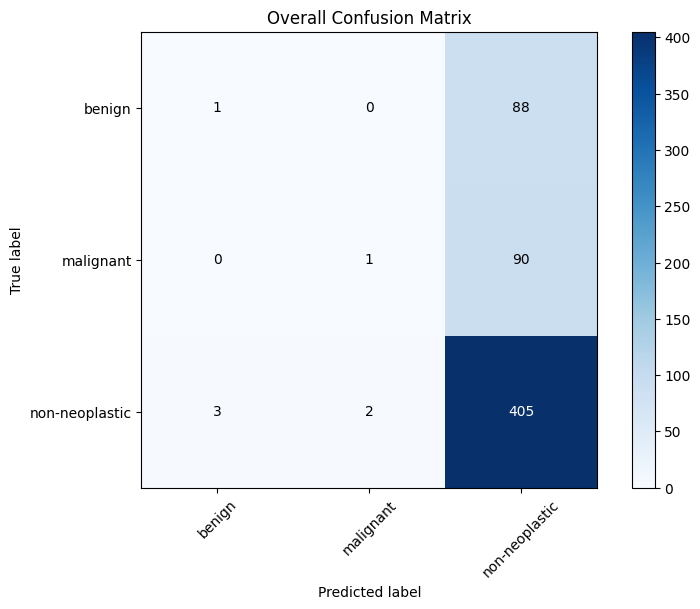

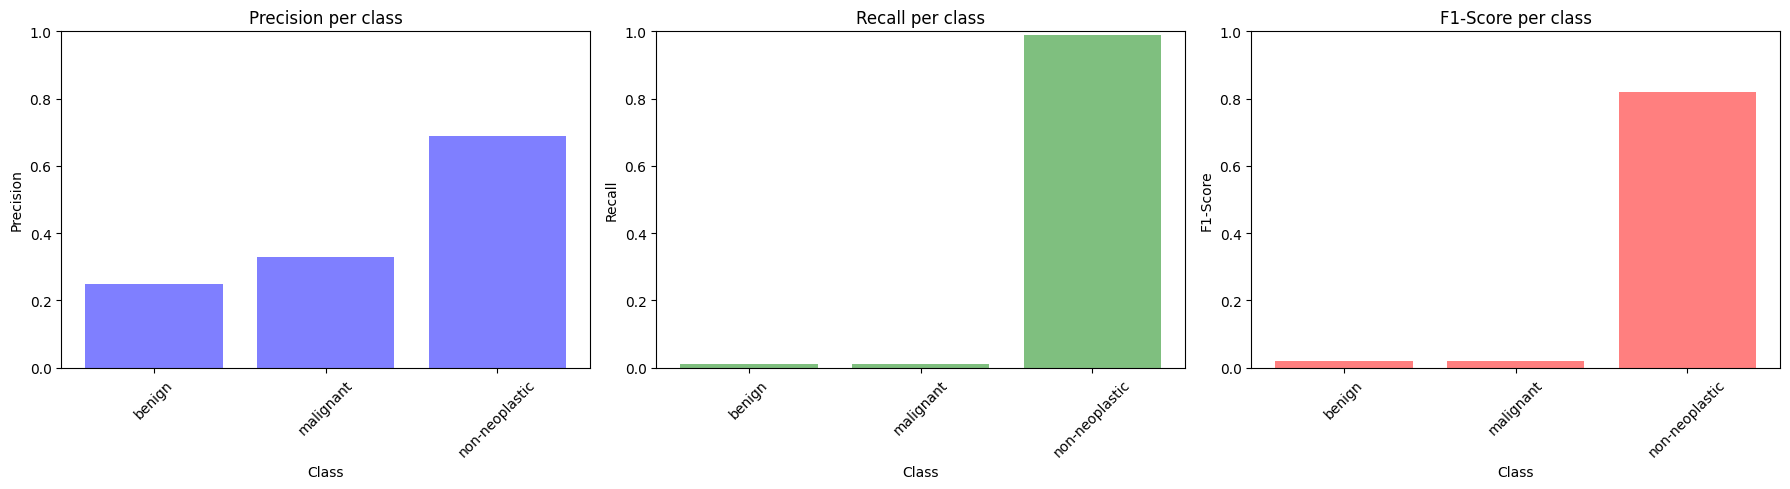

Evaluation for: /content/drive/MyDrive/Client6_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 45s 2s/step
Confusion Matrix:
[[  0   8  81]
 [  1   5  85]
 [  5  18 387]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.00      0.00      0.00        89
     malignant       0.16      0.05      0.08        91
non-neoplastic       0.70      0.94      0.80       410

      accuracy                           0.66       590
     macro avg       0.29      0.33      0.30       590
  weighted avg       0.51      0.66      0.57       590



<ipython-input-2-1472dbc2a86e>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-2-1472dbc2a86e>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


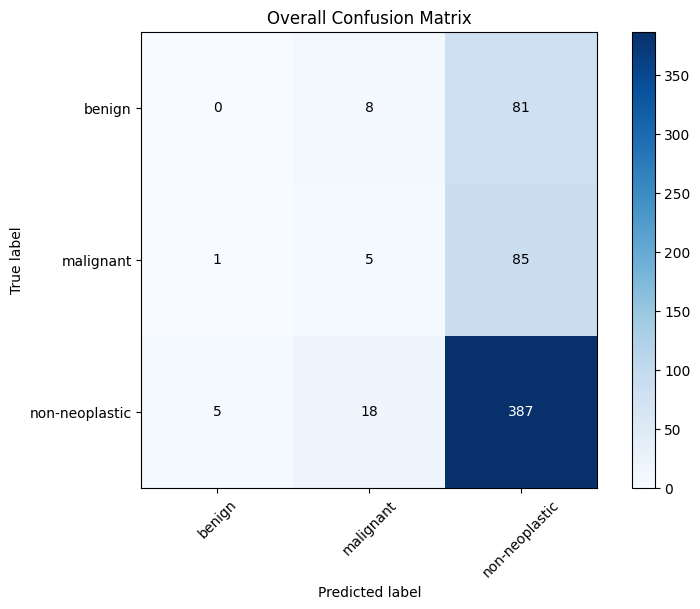

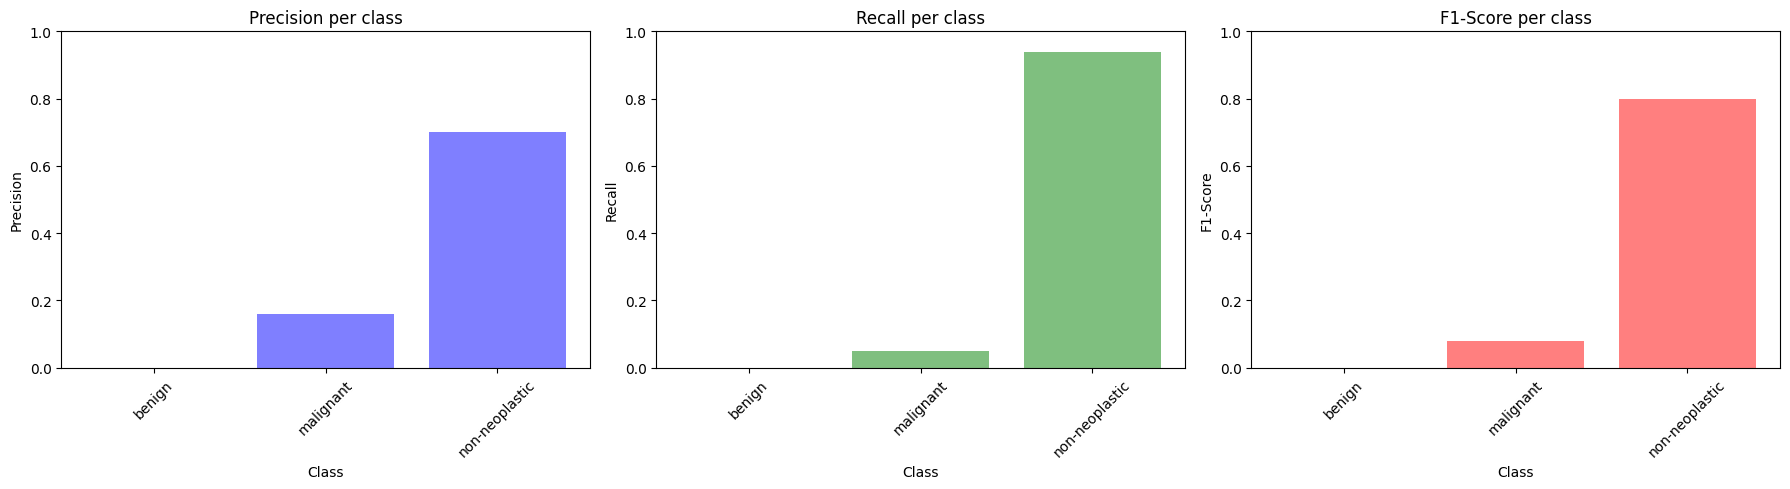

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

def evaluate_model(model_path):
    # Load the model
    model = load_model(model_path)

    # Load test data
    test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, "Client1_SplitData", "test"),
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    # Use the test generator to make predictions
    predictions = model.predict(test_generator)

    # Convert one-hot encoded predictions back to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class labels from the test generator
    true_classes = test_generator.classes

    # Get class labels for the confusion matrix
    class_labels = list(test_generator.class_indices.keys())

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)

    # Calculate accuracy, precision, recall, and F1-score
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_mtx)

    # Print accuracy, precision, recall, and F1-score
    print("\nClassification Report:")
    print(report)

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes=class_labels)

    # Plot precision, recall, and F1-score per class
    plot_metrics_per_class(report)

# Paths to models for different clients
model_paths = [
    "/content/drive/MyDrive/Client1_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client2_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client3_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client4_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client5_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client6_Round20_DenseNet201.h5"
]

# Evaluate each model
for model_path in model_paths:
    print("Evaluation for:", model_path)
    evaluate_model(model_path)


Evaluation for: /content/drive/MyDrive/Client1_Round20_DenseNet201.h5
Found 590 images belonging to 3 classes.
19/19 [==============================] - 44s 2s/step
Confusion Matrix:
[[  3   8  78]
 [  1  12  78]
 [ 33  30 347]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.08      0.03      0.05        89
     malignant       0.24      0.13      0.17        91
non-neoplastic       0.69      0.85      0.76       410

      accuracy                           0.61       590
     macro avg       0.34      0.34      0.33       590
  weighted avg       0.53      0.61      0.56       590



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


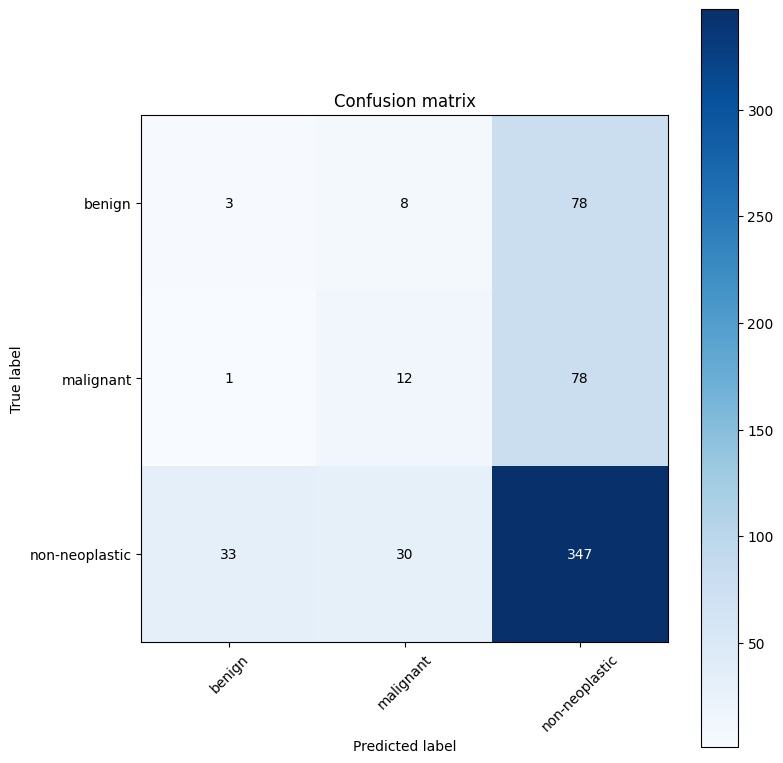

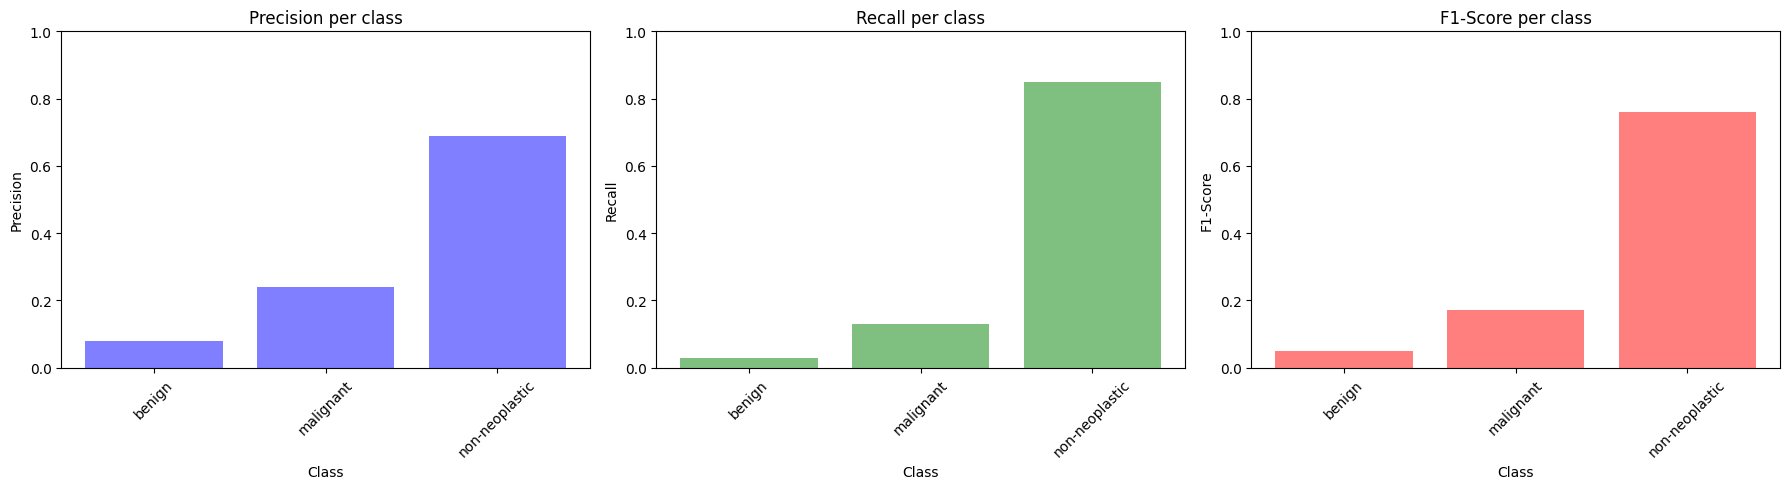

Evaluation for: /content/drive/MyDrive/Client2_Round20_DenseNet201.h5
Found 961 images belonging to 3 classes.
31/31 [==============================] - 72s 2s/step
Confusion Matrix:
[[  7   3 125]
 [ 13   8 128]
 [ 41  72 564]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.11      0.05      0.07       135
     malignant       0.10      0.05      0.07       149
non-neoplastic       0.69      0.83      0.76       677

      accuracy                           0.60       961
     macro avg       0.30      0.31      0.30       961
  weighted avg       0.52      0.60      0.55       961



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


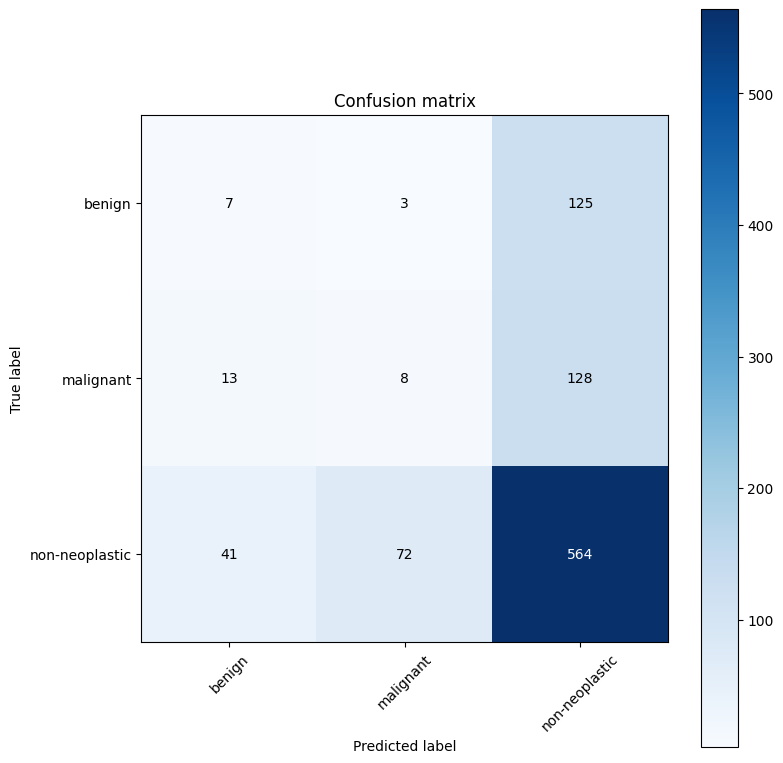

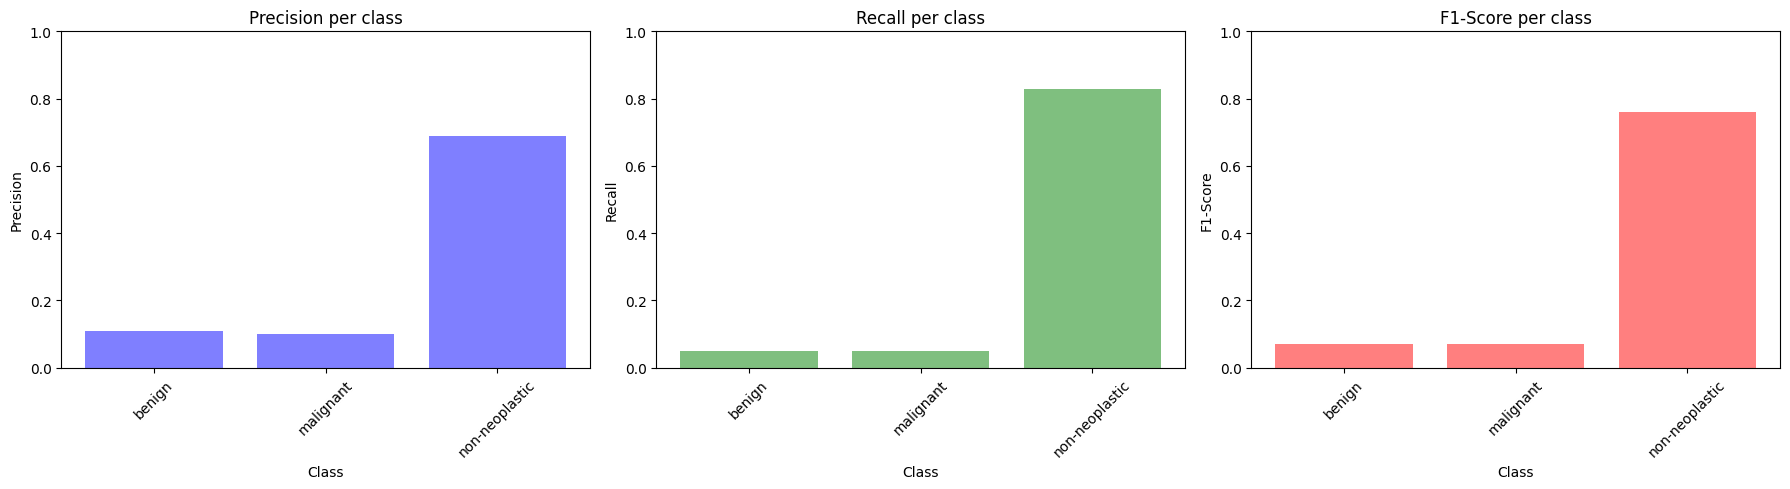

Evaluation for: /content/drive/MyDrive/Client3_Round20_DenseNet201.h5
Found 661 images belonging to 3 classes.
21/21 [==============================] - 49s 2s/step
Confusion Matrix:
[[  5   7  83]
 [  5   6  81]
 [ 22  25 427]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.16      0.05      0.08        95
     malignant       0.16      0.07      0.09        92
non-neoplastic       0.72      0.90      0.80       474

      accuracy                           0.66       661
     macro avg       0.35      0.34      0.32       661
  weighted avg       0.56      0.66      0.60       661



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


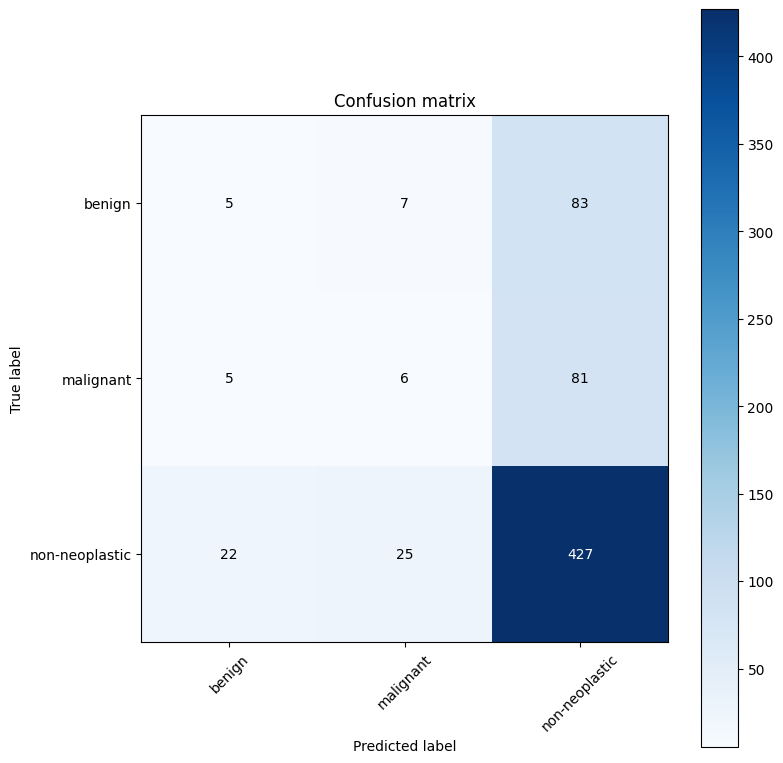

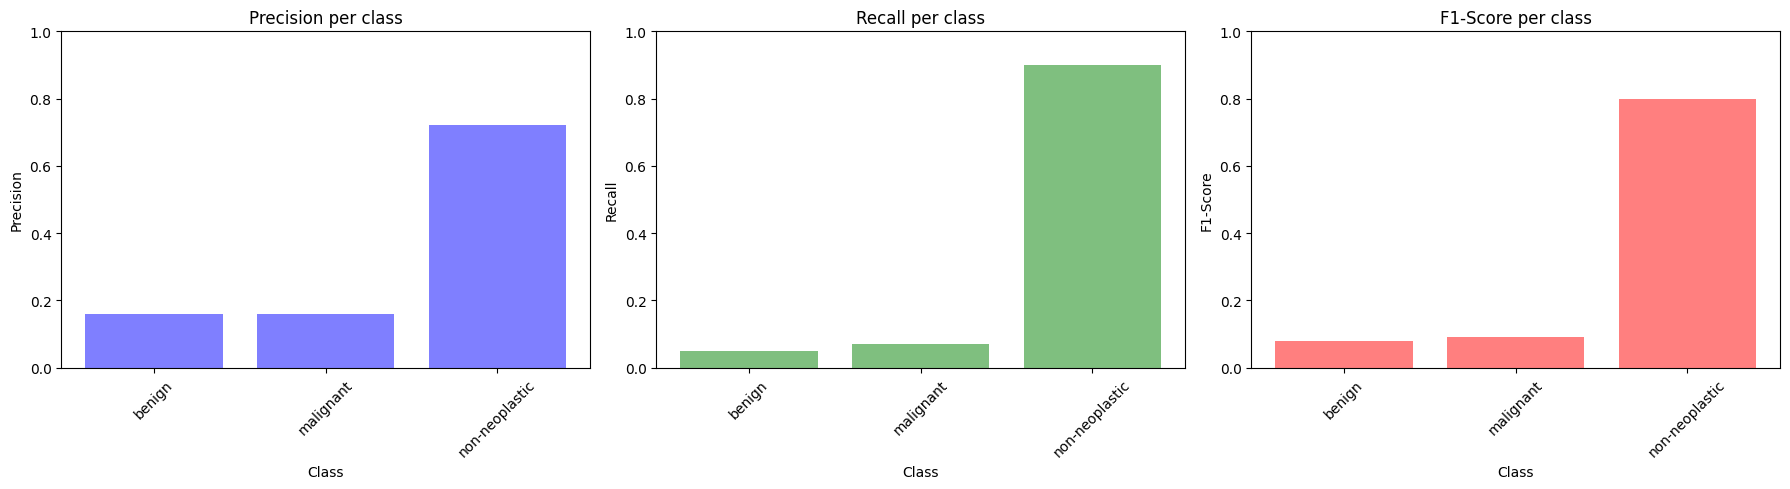

Evaluation for: /content/drive/MyDrive/Client4_Round20_DenseNet201.h5
Found 557 images belonging to 3 classes.
18/18 [==============================] - 43s 2s/step
Confusion Matrix:
[[  1   4  69]
 [  1   3  57]
 [ 11  12 399]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.08      0.01      0.02        74
     malignant       0.16      0.05      0.07        61
non-neoplastic       0.76      0.95      0.84       422

      accuracy                           0.72       557
     macro avg       0.33      0.34      0.31       557
  weighted avg       0.60      0.72      0.65       557



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


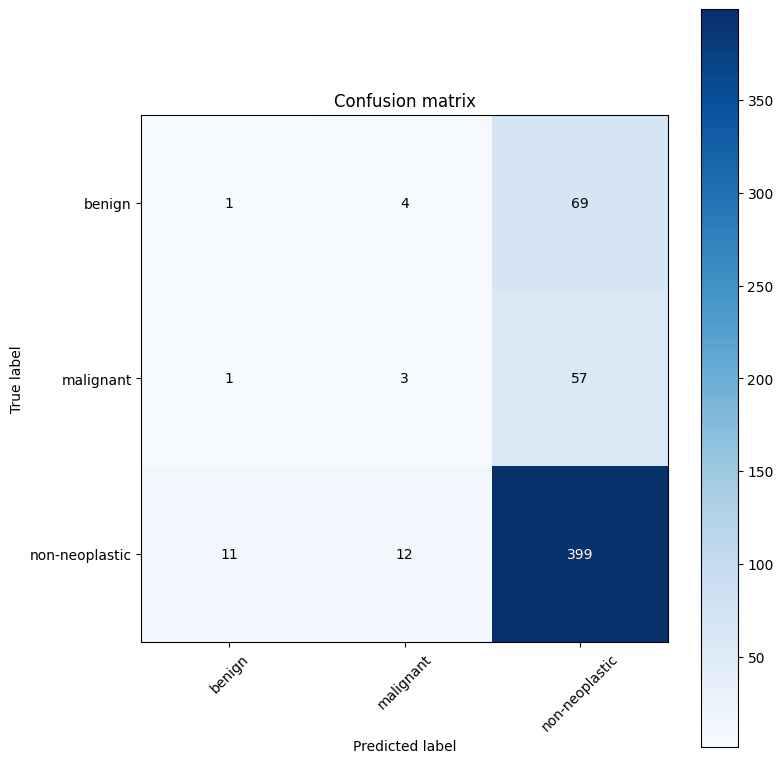

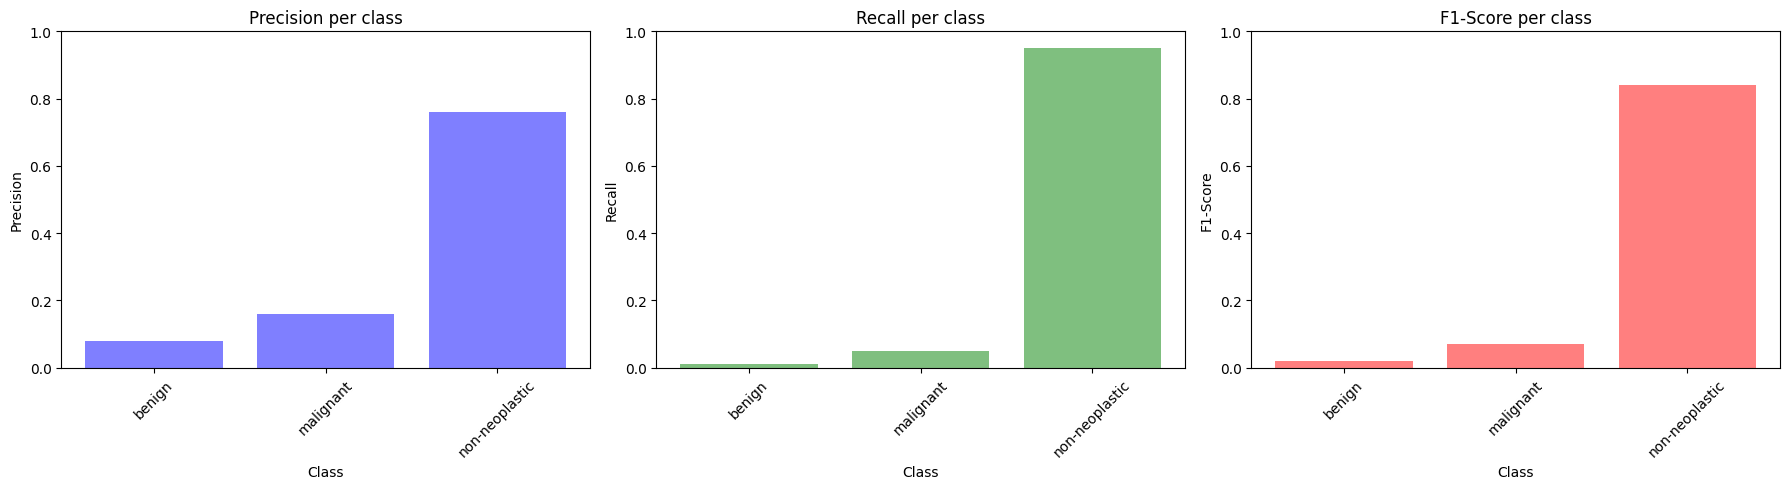

Evaluation for: /content/drive/MyDrive/Client5_Round20_DenseNet201.h5
Found 307 images belonging to 3 classes.
10/10 [==============================] - 25s 2s/step
Confusion Matrix:
[[  1   0  31]
 [  1   1  28]
 [  0   3 242]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.50      0.03      0.06        32
     malignant       0.25      0.03      0.06        30
non-neoplastic       0.80      0.99      0.89       245

      accuracy                           0.79       307
     macro avg       0.52      0.35      0.33       307
  weighted avg       0.72      0.79      0.72       307



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


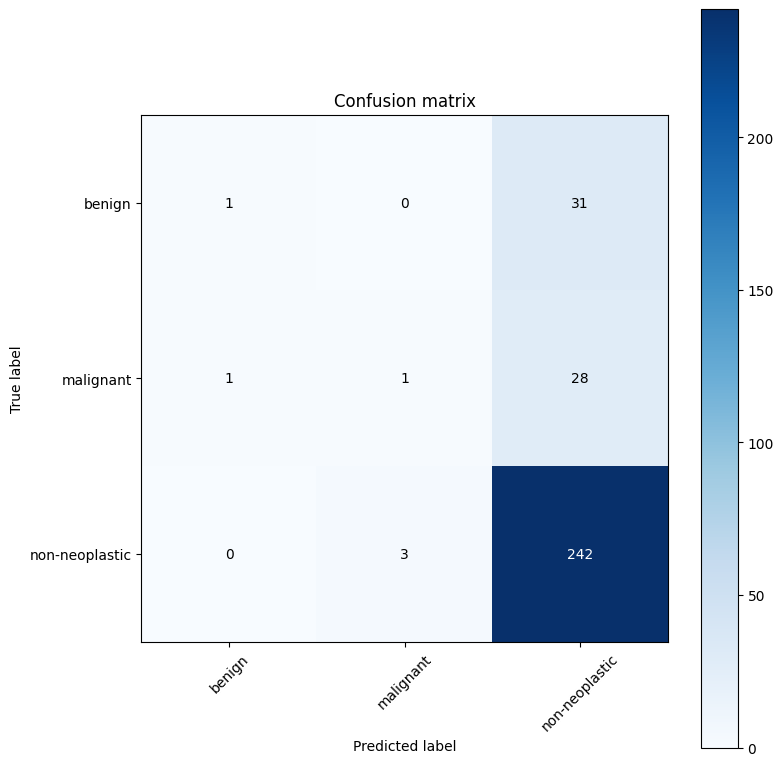

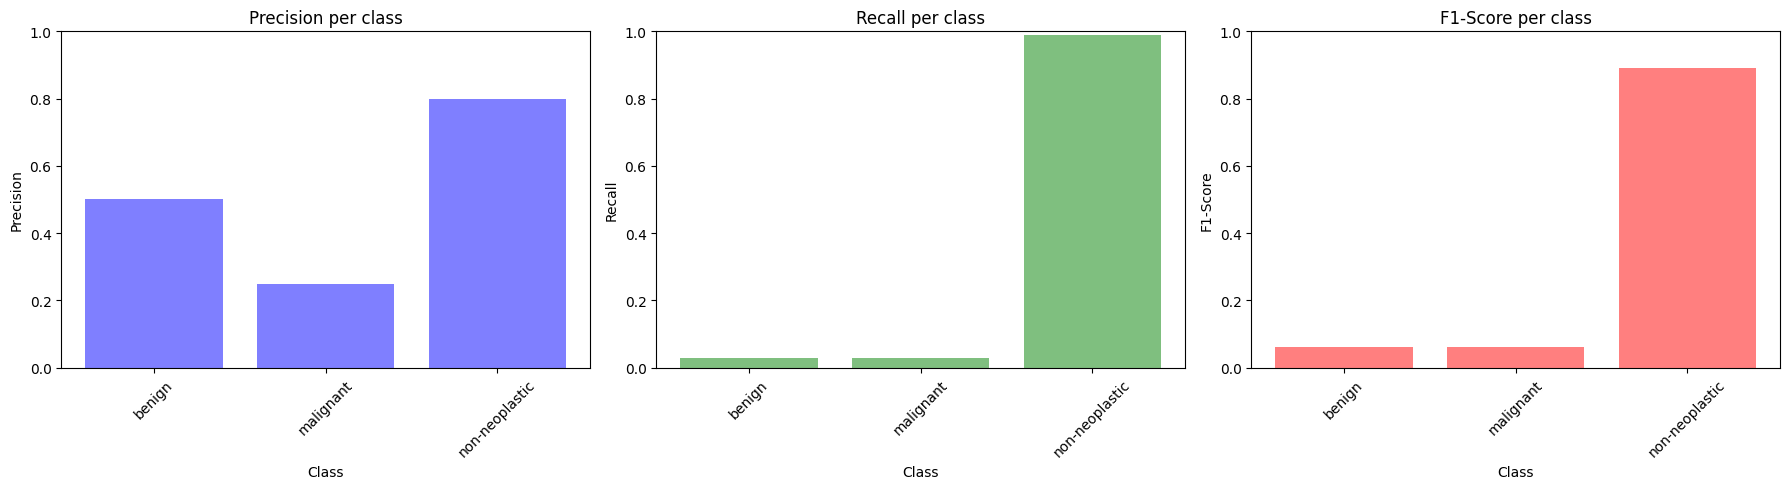

Evaluation for: /content/drive/MyDrive/Client6_Round20_DenseNet201.h5
Found 126 images belonging to 3 classes.
4/4 [==============================] - 13s 2s/step
Confusion Matrix:
[[  1   0   8]
 [  0   0  12]
 [  1   3 101]]

Classification Report:
                precision    recall  f1-score   support

        benign       0.50      0.11      0.18         9
     malignant       0.00      0.00      0.00        12
non-neoplastic       0.83      0.96      0.89       105

      accuracy                           0.81       126
     macro avg       0.44      0.36      0.36       126
  weighted avg       0.73      0.81      0.76       126



<ipython-input-19-8d967d1b38b7>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=45)
<ipython-input-19-8d967d1b38b7>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes, rotation=45)


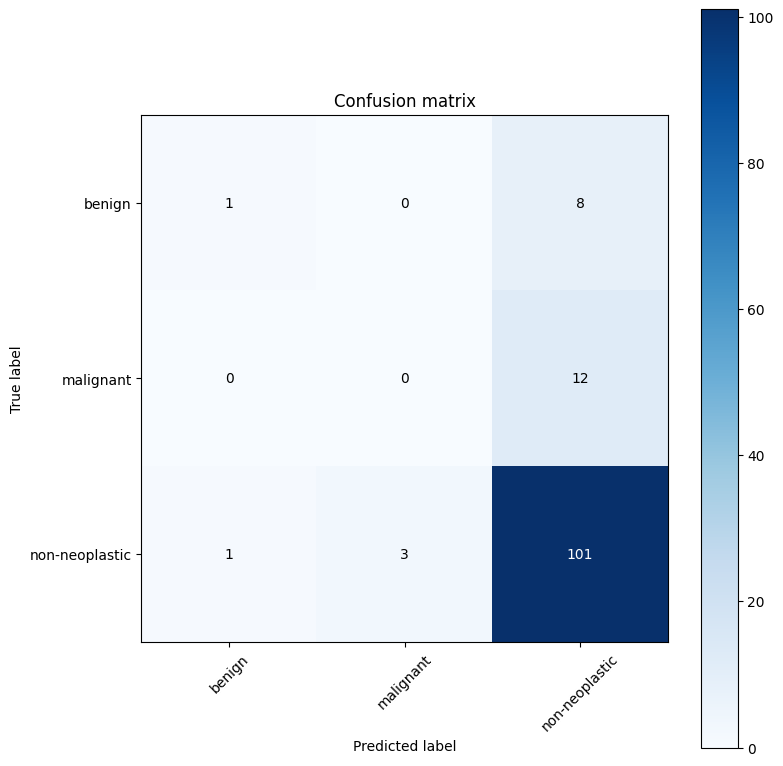

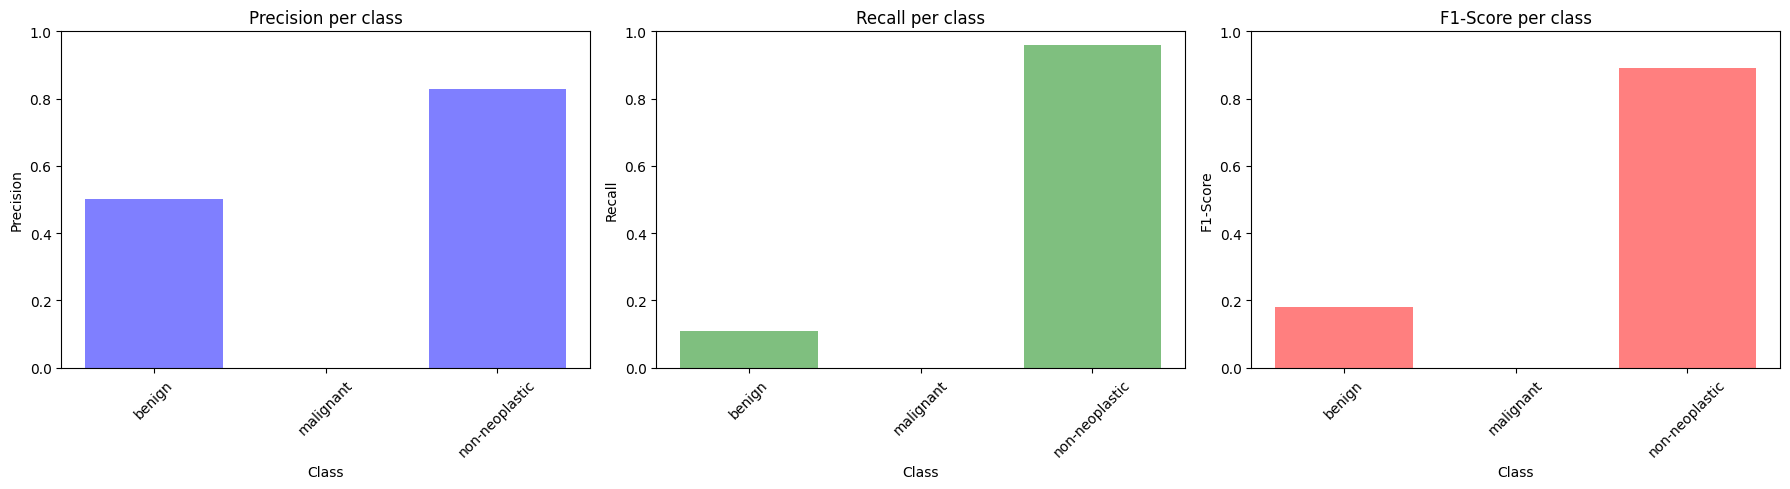

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base directory where your split data is stored
base_dir = "/content/drive/MyDrive/"

# Define the categories
categories = ["non-neoplastic", "malignant", "benign"]

# Define data generators for test sets
batch_size = 32
img_size = (128, 128)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

def evaluate_model(model_path, test_data_dir):
    # Load the model
    model = load_model(model_path)

    # Load test data
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    # Use the test generator to make predictions
    predictions = model.predict(test_generator)

    # Convert one-hot encoded predictions back to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class labels from the test generator
    true_classes = test_generator.classes

    # Get class labels for the confusion matrix
    class_labels = list(test_generator.class_indices.keys())

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)

    # Calculate accuracy, precision, recall, and F1-score
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_mtx)

    # Print accuracy, precision, recall, and F1-score
    print("\nClassification Report:")
    print(report)

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes=class_labels)

    # Plot precision, recall, and F1-score per class
    plot_metrics_per_class(report)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_metrics_per_class(classification_report):
    metrics_per_class = classification_report.split('\n')[2:-5]
    classes = [m.split()[0] for m in metrics_per_class]
    precision = []
    recall = []
    f1_score = []

    for m in metrics_per_class:
        t = m.split()
        if len(t) > 3:
            precision.append(float(t[1]))
            recall.append(float(t[2]))
            f1_score.append(float(t[3]))

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].bar(classes, precision, color='b', alpha=0.5)
    ax[0].set_title('Precision per class')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlabel('Class')
    ax[0].set_xticklabels(classes, rotation=45)
    ax[0].set_ylim([0, 1])

    ax[1].bar(classes, recall, color='g', alpha=0.5)
    ax[1].set_title('Recall per class')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Class')
    ax[1].set_xticklabels(classes, rotation=45)
    ax[1].set_ylim([0, 1])

    ax[2].bar(classes, f1_score, color='r', alpha=0.5)
    ax[2].set_title('F1-Score per class')
    ax[2].set_ylabel('F1-Score')
    ax[2].set_xlabel('Class')
    ax[2].set_xticklabels(classes, rotation=45)
    ax[2].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

# Paths to models for different clients
model_paths = [
    "/content/drive/MyDrive/Client1_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client2_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client3_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client4_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client5_Round20_DenseNet201.h5",
    "/content/drive/MyDrive/Client6_Round20_DenseNet201.h5"
]

# Test data directories for different clients
test_data_dirs = [
    os.path.join(base_dir, "Client1_SplitData", "test"),
    os.path.join(base_dir, "Client2_SplitData", "test"),
    os.path.join(base_dir, "Client3_SplitData", "test"),
    os.path.join(base_dir, "Client4_SplitData", "test"),
    os.path.join(base_dir, "Client5_SplitData", "test"),
    os.path.join(base_dir, "Client6_SplitData", "test")
]

# Evaluate each model for each client
for model_path, test_data_dir in zip(model_paths, test_data_dirs):
    print("Evaluation for:", model_path)
    evaluate_model(model_path, test_data_dir)

